# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 4D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$.
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_4D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 4 
data_points_exp = 20000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")
# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
cvx_samples_exp_tensor = cvx_samples_exp_tensor.to(device)

Generated training data: y_j_exp_tensor shape torch.Size([20000, 4]), cvx_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L1 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_quad_l1.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---


iteration 0 loss 4.6258625984191895
iteration 0 loss 36.81763458251953


iteration 500 loss 1.3638739585876465


iteration 1000 loss 1.3118562698364258


iteration 1500 loss 1.2240427732467651


iteration 2000 loss 1.0685094594955444


iteration 2500 loss 0.7632014751434326


iteration 3000 loss 0.3154354393482208


iteration 3500 loss 0.18250523507595062


iteration 4000 loss 0.1532144993543625


iteration 4500 loss 0.13109725713729858


iteration 5000 loss 0.11957573145627975


iteration 5500 loss 0.11077699065208435


iteration 6000 loss 0.10599657893180847


iteration 6500 loss 0.10259973257780075


iteration 7000 loss 0.10042368620634079


iteration 7500 loss 0.09870728850364685


iteration 8000 loss 0.09730268269777298


iteration 8500 loss 0.09620058536529541


iteration 9000 loss 0.09525343775749207


iteration 9500 loss 0.09447307884693146


iteration 10000 loss 0.09381851553916931


iteration 10500 loss 0.09324600547552109


iteration 11000 loss 0.09367803484201431


iteration 11500 loss 0.09236554056406021


iteration 12000 loss 0.09269195050001144


iteration 12500 loss 0.09172102063894272


iteration 13000 loss 0.09147632122039795


iteration 13500 loss 0.0911932960152626


iteration 14000 loss 0.09164026379585266


iteration 14500 loss 0.09097575396299362


iteration 15000 loss 0.09202862530946732


iteration 15500 loss 0.09146597981452942


iteration 16000 loss 0.0912880003452301


iteration 16500 loss 0.08998138457536697


iteration 17000 loss 0.09016098082065582


iteration 17500 loss 0.09021467715501785


iteration 18000 loss 0.08942244946956635


iteration 18500 loss 0.08988785743713379


iteration 19000 loss 0.08905979990959167


iteration 19500 loss 0.08930709958076477


iteration 20000 loss 0.09109476953744888


iteration 20500 loss 0.08853854238986969


iteration 21000 loss 0.08926824480295181


iteration 21500 loss 0.08818580955266953


iteration 22000 loss 0.08800452947616577


iteration 22500 loss 0.08781829476356506


iteration 23000 loss 0.0882938876748085


iteration 23500 loss 0.08798495680093765


iteration 24000 loss 0.08894199877977371


iteration 24500 loss 0.08724917471408844


iteration 25000 loss 0.08687645196914673


iteration 25500 loss 0.0870848000049591


iteration 26000 loss 0.08828648179769516


iteration 26500 loss 0.08627157658338547


iteration 27000 loss 0.08665262162685394


iteration 27500 loss 0.0858425423502922


iteration 28000 loss 0.08743087947368622


iteration 28500 loss 0.08540784567594528


iteration 29000 loss 0.08865974098443985


iteration 29500 loss 0.08496331423521042


iteration 30000 loss 0.08702944219112396


iteration 30500 loss 0.08452525734901428


iteration 31000 loss 0.0842510238289833


iteration 31500 loss 0.08401639014482498


iteration 32000 loss 0.08553483337163925


iteration 32500 loss 0.08354318886995316


iteration 33000 loss 0.08554637432098389


iteration 33500 loss 0.08305122703313828


iteration 34000 loss 0.08281568437814713


iteration 34500 loss 0.0825764387845993


iteration 35000 loss 0.08234300464391708


iteration 35500 loss 0.08348638564348221


iteration 36000 loss 0.08183293789625168


iteration 36500 loss 0.08159522712230682


iteration 37000 loss 0.08136314153671265


iteration 37500 loss 0.08110259473323822


iteration 38000 loss 0.08088269829750061


iteration 38500 loss 0.08061778545379639


iteration 39000 loss 0.08036963641643524


iteration 39500 loss 0.08022840321063995


iteration 40000 loss 0.07989613711833954


iteration 40500 loss 0.08167547732591629


iteration 41000 loss 0.07978038489818573


iteration 41500 loss 0.07917819172143936


iteration 42000 loss 0.07893972098827362


iteration 42500 loss 0.07871410995721817


iteration 43000 loss 0.07848417013883591


iteration 43500 loss 0.07823927700519562


iteration 44000 loss 0.07801271975040436


iteration 44500 loss 0.07777594029903412


iteration 45000 loss 0.07864022254943848


iteration 45500 loss 0.07729318737983704


iteration 46000 loss 0.07724465429782867


iteration 46500 loss 0.07684986293315887


iteration 47000 loss 0.07660814374685287


iteration 47500 loss 0.07637841254472733


iteration 48000 loss 0.07615332305431366


iteration 48500 loss 0.07591889053583145


iteration 49000 loss 0.07577762007713318


iteration 49500 loss 0.07647177577018738


iteration 50000 loss 0.0752604752779007


iteration 50500 loss 0.0750264972448349


iteration 51000 loss 0.07480573654174805


iteration 51500 loss 0.07458165287971497


iteration 52000 loss 0.07436495274305344


iteration 52500 loss 0.07417953014373779


iteration 53000 loss 0.07392677664756775


iteration 53500 loss 0.07369305193424225


iteration 54000 loss 0.07352700084447861


iteration 54500 loss 0.07326129078865051


iteration 55000 loss 0.07304254174232483


iteration 55500 loss 0.07283256947994232


iteration 56000 loss 0.0725896954536438


iteration 56500 loss 0.07238169014453888


iteration 57000 loss 0.07216813415288925


iteration 57500 loss 0.07194680720567703


iteration 58000 loss 0.07394139468669891


iteration 58500 loss 0.0715862512588501


iteration 59000 loss 0.07130566239356995


iteration 59500 loss 0.07108235359191895


iteration 60000 loss 0.07089096307754517


iteration 60500 loss 0.07162736356258392


iteration 61000 loss 0.07044622302055359


iteration 61500 loss 0.07024627178907394


iteration 62000 loss 0.07004706561565399


iteration 62500 loss 0.06984620541334152


iteration 63000 loss 0.07375330477952957


iteration 63500 loss 0.06944207102060318


iteration 64000 loss 0.06925635039806366


iteration 64500 loss 0.06905458867549896


iteration 65000 loss 0.06885997951030731


iteration 65500 loss 0.06867308169603348


iteration 66000 loss 0.0684889480471611


iteration 66500 loss 0.0683090016245842


iteration 67000 loss 0.06813134253025055


iteration 67500 loss 0.06795459985733032


iteration 68000 loss 0.06777460873126984


iteration 68500 loss 0.06760399788618088


iteration 69000 loss 0.06743019819259644


iteration 69500 loss 0.07045432925224304


iteration 70000 loss 0.06937538832426071


iteration 70500 loss 0.06760001182556152


iteration 71000 loss 0.06715507805347443


iteration 71500 loss 0.06659457832574844


iteration 72000 loss 0.06644002348184586


iteration 72500 loss 0.06626889109611511


iteration 73000 loss 0.06610941141843796


iteration 73500 loss 0.06599794328212738


iteration 74000 loss 0.06583623588085175


iteration 74500 loss 0.06562846899032593


iteration 75000 loss 0.06547749042510986


iteration 75500 loss 0.06532710790634155


iteration 76000 loss 0.0651618167757988


iteration 76500 loss 0.06501337885856628


iteration 77000 loss 0.06486761569976807


iteration 77500 loss 0.06471554934978485


iteration 78000 loss 0.06457006931304932


iteration 78500 loss 0.06442737579345703


iteration 79000 loss 0.0642869845032692


iteration 79500 loss 0.06414876133203506


iteration 80000 loss 0.06401830166578293


iteration 80500 loss 0.06386815011501312


iteration 81000 loss 0.06484006345272064


iteration 81500 loss 0.06524555385112762


iteration 82000 loss 0.06345952302217484


iteration 82500 loss 0.06332717090845108


iteration 83000 loss 0.06319326907396317


iteration 83500 loss 0.06307005137205124


iteration 84000 loss 0.06296432018280029


iteration 84500 loss 0.06281234323978424


iteration 85000 loss 0.06267215311527252


iteration 85500 loss 0.06256236135959625


iteration 86000 loss 0.06241274252533913


iteration 86500 loss 0.06228107213973999


iteration 87000 loss 0.062153417617082596


iteration 87500 loss 0.06481858342885971


iteration 88000 loss 0.061899010092020035


iteration 88500 loss 0.06177559494972229


iteration 89000 loss 0.061649248003959656


iteration 89500 loss 0.06152486428618431


iteration 90000 loss 0.06139974296092987


iteration 90500 loss 0.0612805038690567


iteration 91000 loss 0.06126794219017029


iteration 91500 loss 0.06102963536977768


iteration 92000 loss 0.06090954318642616


iteration 92500 loss 0.061426449567079544


iteration 93000 loss 0.06066662445664406


iteration 93500 loss 0.06055209040641785


iteration 94000 loss 0.06042977049946785


iteration 94500 loss 0.060380950570106506


iteration 95000 loss 0.06019628047943115


iteration 95500 loss 0.060159508138895035


iteration 96000 loss 0.0599604956805706


iteration 96500 loss 0.059845663607120514


iteration 97000 loss 0.05974410101771355


iteration 97500 loss 0.05961628258228302


iteration 98000 loss 0.05950900912284851


iteration 98500 loss 0.05939256399869919


iteration 99000 loss 0.05931708961725235


iteration 99500 loss 0.059176404029130936


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.05907328426837921


iteration 100500 loss 0.05905203893780708


iteration 101000 loss 0.05903603509068489


iteration 101500 loss 0.0590156614780426


iteration 102000 loss 0.0589899942278862


iteration 102500 loss 0.05895824357867241


iteration 103000 loss 0.05891910940408707


iteration 103500 loss 0.05886855348944664


iteration 104000 loss 0.0588100329041481


iteration 104500 loss 0.05874710530042648


iteration 105000 loss 0.058678772300481796


iteration 105500 loss 0.05860823765397072


iteration 106000 loss 0.058540355414152145


iteration 106500 loss 0.05846951901912689


iteration 107000 loss 0.05840026214718819


iteration 107500 loss 0.058332812041044235


iteration 108000 loss 0.05826536566019058


iteration 108500 loss 0.05819600820541382


iteration 109000 loss 0.05812840536236763


iteration 109500 loss 0.058061227202415466


iteration 110000 loss 0.0579969696700573


iteration 110500 loss 0.05792952701449394


iteration 111000 loss 0.05786231532692909


iteration 111500 loss 0.05779178440570831


iteration 112000 loss 0.05772124603390694


iteration 112500 loss 0.057652514427900314


iteration 113000 loss 0.05758428946137428


iteration 113500 loss 0.057516489177942276


iteration 114000 loss 0.0574505478143692


iteration 114500 loss 0.05738748610019684


iteration 115000 loss 0.057321373373270035


iteration 115500 loss 0.057255566120147705


iteration 116000 loss 0.05719350278377533


iteration 116500 loss 0.05712857469916344


iteration 117000 loss 0.057066239416599274


iteration 117500 loss 0.05700154975056648


iteration 118000 loss 0.05693638697266579


iteration 118500 loss 0.05687204375863075


iteration 119000 loss 0.05680389702320099


iteration 119500 loss 0.05673876777291298


iteration 120000 loss 0.05667594447731972


iteration 120500 loss 0.0566069670021534


iteration 121000 loss 0.056542400270700455


iteration 121500 loss 0.056478556245565414


iteration 122000 loss 0.05641535669565201


iteration 122500 loss 0.05634870380163193


iteration 123000 loss 0.056284233927726746


iteration 123500 loss 0.05621969327330589


iteration 124000 loss 0.05615423992276192


iteration 124500 loss 0.05609320104122162


iteration 125000 loss 0.0560273677110672


iteration 125500 loss 0.0559663362801075


iteration 126000 loss 0.055909715592861176


iteration 126500 loss 0.05585205554962158


iteration 127000 loss 0.05579317361116409


iteration 127500 loss 0.055737968534231186


iteration 128000 loss 0.0556817501783371


iteration 128500 loss 0.055627353489398956


iteration 129000 loss 0.05557427927851677


iteration 129500 loss 0.05552144721150398


iteration 130000 loss 0.055469363927841187


iteration 130500 loss 0.0554182343184948


iteration 131000 loss 0.05536630004644394


iteration 131500 loss 0.05531814321875572


iteration 132000 loss 0.05526917427778244


iteration 132500 loss 0.055213846266269684


iteration 133000 loss 0.055166106671094894


iteration 133500 loss 0.055114664137363434


iteration 134000 loss 0.05506540462374687


iteration 134500 loss 0.055016715079545975


iteration 135000 loss 0.05497077479958534


iteration 135500 loss 0.05492061749100685


iteration 136000 loss 0.054877184331417084


iteration 136500 loss 0.054826583713293076


iteration 137000 loss 0.05477707460522652


iteration 137500 loss 0.05472993105649948


iteration 138000 loss 0.05468244478106499


iteration 138500 loss 0.05463375896215439


iteration 139000 loss 0.05458608269691467


iteration 139500 loss 0.054540954530239105


iteration 140000 loss 0.054491546005010605


iteration 140500 loss 0.05444328486919403


iteration 141000 loss 0.05439722165465355


iteration 141500 loss 0.054350804537534714


iteration 142000 loss 0.05430213361978531


iteration 142500 loss 0.05425539240241051


iteration 143000 loss 0.05421038717031479


iteration 143500 loss 0.0541602298617363


iteration 144000 loss 0.05411539599299431


iteration 144500 loss 0.054068394005298615


iteration 145000 loss 0.054020676761865616


iteration 145500 loss 0.05397595092654228


iteration 146000 loss 0.053929638117551804


iteration 146500 loss 0.05388018116354942


iteration 147000 loss 0.05383433774113655


iteration 147500 loss 0.0537872314453125


iteration 148000 loss 0.05374361574649811


iteration 148500 loss 0.05369441956281662


iteration 149000 loss 0.053648728877305984


iteration 149500 loss 0.05360419675707817


iteration 150000 loss 0.05355865880846977


iteration 150500 loss 0.05351635441184044


iteration 151000 loss 0.05347374081611633


iteration 151500 loss 0.05342940613627434


iteration 152000 loss 0.053383372724056244


iteration 152500 loss 0.05333957448601723


iteration 153000 loss 0.05329478159546852


iteration 153500 loss 0.0532526858150959


iteration 154000 loss 0.05320446565747261


iteration 154500 loss 0.053163327276706696


iteration 155000 loss 0.053117211908102036


iteration 155500 loss 0.05306876078248024


iteration 156000 loss 0.05302313715219498


iteration 156500 loss 0.05297844111919403


iteration 157000 loss 0.05293307453393936


iteration 157500 loss 0.052886106073856354


iteration 158000 loss 0.05284205079078674


iteration 158500 loss 0.05279644578695297


iteration 159000 loss 0.05274970456957817


iteration 159500 loss 0.05270635709166527


iteration 160000 loss 0.05266004055738449


iteration 160500 loss 0.052612852305173874


iteration 161000 loss 0.05256795510649681


iteration 161500 loss 0.052522141486406326


iteration 162000 loss 0.05247661471366882


iteration 162500 loss 0.05243309214711189


iteration 163000 loss 0.05238614231348038


iteration 163500 loss 0.05234136804938316


iteration 164000 loss 0.05229908972978592


iteration 164500 loss 0.052252691239118576


iteration 165000 loss 0.05220862850546837


iteration 165500 loss 0.05216600373387337


iteration 166000 loss 0.05211852863430977


iteration 166500 loss 0.052073948085308075


iteration 167000 loss 0.052030883729457855


iteration 167500 loss 0.05198610574007034


iteration 168000 loss 0.05194058641791344


iteration 168500 loss 0.05189850926399231


iteration 169000 loss 0.05185290426015854


iteration 169500 loss 0.051813408732414246


iteration 170000 loss 0.05176600068807602


iteration 170500 loss 0.05172349885106087


iteration 171000 loss 0.05168387293815613


iteration 171500 loss 0.05164041742682457


iteration 172000 loss 0.05159552022814751


iteration 172500 loss 0.051555320620536804


iteration 173000 loss 0.05150952190160751


iteration 173500 loss 0.05146576464176178


iteration 174000 loss 0.05142248421907425


iteration 174500 loss 0.05138060078024864


iteration 175000 loss 0.05133730173110962


iteration 175500 loss 0.051298949867486954


iteration 176000 loss 0.051256176084280014


iteration 176500 loss 0.05121340975165367


iteration 177000 loss 0.05117164924740791


iteration 177500 loss 0.05113063380122185


iteration 178000 loss 0.05109156668186188


iteration 178500 loss 0.05104884132742882


iteration 179000 loss 0.051007602363824844


iteration 179500 loss 0.050967294722795486


iteration 180000 loss 0.05092550069093704


iteration 180500 loss 0.050884801894426346


iteration 181000 loss 0.05084596201777458


iteration 181500 loss 0.05080293491482735


iteration 182000 loss 0.05076297000050545


iteration 182500 loss 0.05072304606437683


iteration 183000 loss 0.050678931176662445


iteration 183500 loss 0.050638213753700256


iteration 184000 loss 0.05059616267681122


iteration 184500 loss 0.05055439472198486


iteration 185000 loss 0.0505116805434227


iteration 185500 loss 0.05047035962343216


iteration 186000 loss 0.05042645335197449


iteration 186500 loss 0.05038238316774368


iteration 187000 loss 0.050339773297309875


iteration 187500 loss 0.05029398575425148


iteration 188000 loss 0.05024927109479904


iteration 188500 loss 0.05020442605018616


iteration 189000 loss 0.05016258358955383


iteration 189500 loss 0.05011460930109024


iteration 190000 loss 0.050071414560079575


iteration 190500 loss 0.050029683858156204


iteration 191000 loss 0.049982767552137375


iteration 191500 loss 0.049940016120672226


iteration 192000 loss 0.049898263067007065


iteration 192500 loss 0.04985426738858223


iteration 193000 loss 0.04980960115790367


iteration 193500 loss 0.04976879060268402


iteration 194000 loss 0.04972454160451889


iteration 194500 loss 0.04968404024839401


iteration 195000 loss 0.049639709293842316


iteration 195500 loss 0.04959545284509659


iteration 196000 loss 0.04955154284834862


iteration 196500 loss 0.04950978234410286


iteration 197000 loss 0.04946558177471161


iteration 197500 loss 0.049422573298215866


iteration 198000 loss 0.04937906190752983


iteration 198500 loss 0.04933563619852066


iteration 199000 loss 0.0492926687002182


iteration 199500 loss 0.049251727759838104


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.04920622706413269


iteration 200500 loss 0.04920031130313873


iteration 201000 loss 0.04919428005814552


iteration 201500 loss 0.04918697848916054


iteration 202000 loss 0.04917887598276138


iteration 202500 loss 0.049170657992362976


iteration 203000 loss 0.049162205308675766


iteration 203500 loss 0.04915392026305199


iteration 204000 loss 0.049145959317684174


iteration 204500 loss 0.049138396978378296


iteration 205000 loss 0.04913047328591347


iteration 205500 loss 0.04912300407886505


iteration 206000 loss 0.049115657806396484


iteration 206500 loss 0.04910769313573837


iteration 207000 loss 0.04910003021359444


iteration 207500 loss 0.049092523753643036


iteration 208000 loss 0.0490851104259491


iteration 208500 loss 0.04907764121890068


iteration 209000 loss 0.049070242792367935


iteration 209500 loss 0.04906275123357773


iteration 210000 loss 0.0490553118288517


iteration 210500 loss 0.04904816299676895


iteration 211000 loss 0.04904090613126755


iteration 211500 loss 0.049033720046281815


iteration 212000 loss 0.049026619642972946


iteration 212500 loss 0.04901939257979393


iteration 213000 loss 0.04901241138577461


iteration 213500 loss 0.04900556057691574


iteration 214000 loss 0.04899836331605911


iteration 214500 loss 0.04899144545197487


iteration 215000 loss 0.04898441955447197


iteration 215500 loss 0.04897778853774071


iteration 216000 loss 0.048970647156238556


iteration 216500 loss 0.048963915556669235


iteration 217000 loss 0.048957183957099915


iteration 217500 loss 0.04895045980811119


iteration 218000 loss 0.0489436574280262


iteration 218500 loss 0.04893677681684494


iteration 219000 loss 0.04892978444695473


iteration 219500 loss 0.048922691494226456


iteration 220000 loss 0.04891557618975639


iteration 220500 loss 0.04890843480825424


iteration 221000 loss 0.048901189118623734


iteration 221500 loss 0.048894014209508896


iteration 222000 loss 0.048886969685554504


iteration 222500 loss 0.048880014568567276


iteration 223000 loss 0.04887283220887184


iteration 223500 loss 0.0488656684756279


iteration 224000 loss 0.04885851591825485


iteration 224500 loss 0.04885134845972061


iteration 225000 loss 0.04884417727589607


iteration 225500 loss 0.048837270587682724


iteration 226000 loss 0.04883033409714699


iteration 226500 loss 0.04882322996854782


iteration 227000 loss 0.04881621524691582


iteration 227500 loss 0.04880925640463829


iteration 228000 loss 0.04880238696932793


iteration 228500 loss 0.04879523068666458


iteration 229000 loss 0.04878835752606392


iteration 229500 loss 0.04878123849630356


iteration 230000 loss 0.04877437651157379


iteration 230500 loss 0.048767492175102234


iteration 231000 loss 0.04876038804650307


iteration 231500 loss 0.04875347018241882


iteration 232000 loss 0.04874638095498085


iteration 232500 loss 0.048739444464445114


iteration 233000 loss 0.04873236268758774


iteration 233500 loss 0.048725470900535583


iteration 234000 loss 0.04871860891580582


iteration 234500 loss 0.04871184751391411


iteration 235000 loss 0.048705026507377625


iteration 235500 loss 0.04869822785258293


iteration 236000 loss 0.04869125410914421


iteration 236500 loss 0.048684366047382355


iteration 237000 loss 0.048677388578653336


iteration 237500 loss 0.04867032170295715


iteration 238000 loss 0.048663195222616196


iteration 238500 loss 0.048656195402145386


iteration 239000 loss 0.04864933714270592


iteration 239500 loss 0.04864250868558884


iteration 240000 loss 0.048635512590408325


iteration 240500 loss 0.0486285500228405


iteration 241000 loss 0.04862155020236969


iteration 241500 loss 0.04861423373222351


iteration 242000 loss 0.04860694333910942


iteration 242500 loss 0.04859963804483414


iteration 243000 loss 0.048592593520879745


iteration 243500 loss 0.04858503118157387


iteration 244000 loss 0.04857761785387993


iteration 244500 loss 0.048570044338703156


iteration 245000 loss 0.0485624223947525


iteration 245500 loss 0.04855494201183319


iteration 246000 loss 0.04854726046323776


iteration 246500 loss 0.04853978380560875


iteration 247000 loss 0.04853205010294914


iteration 247500 loss 0.048524606972932816


iteration 248000 loss 0.04851653799414635


iteration 248500 loss 0.048508621752262115


iteration 249000 loss 0.04850061982870102


iteration 249500 loss 0.04849272966384888


iteration 250000 loss 0.04848471283912659


iteration 250500 loss 0.04847666993737221


iteration 251000 loss 0.04846871644258499


iteration 251500 loss 0.04846084862947464


iteration 252000 loss 0.04845287650823593


iteration 252500 loss 0.04844493791460991


iteration 253000 loss 0.04843705892562866


iteration 253500 loss 0.04842911288142204


iteration 254000 loss 0.04842136800289154


iteration 254500 loss 0.04841340705752373


iteration 255000 loss 0.04840577393770218


iteration 255500 loss 0.04839791730046272


iteration 256000 loss 0.048390332609415054


iteration 256500 loss 0.04838286340236664


iteration 257000 loss 0.048375390470027924


iteration 257500 loss 0.048368144780397415


iteration 258000 loss 0.04836023598909378


iteration 258500 loss 0.048352740705013275


iteration 259000 loss 0.0483451783657074


iteration 259500 loss 0.0483376681804657


iteration 260000 loss 0.04833010211586952


iteration 260500 loss 0.048322711139917374


iteration 261000 loss 0.048315200954675674


iteration 261500 loss 0.048308029770851135


iteration 262000 loss 0.04830057919025421


iteration 262500 loss 0.048293180763721466


iteration 263000 loss 0.04828575998544693


iteration 263500 loss 0.04827842116355896


iteration 264000 loss 0.0482712984085083


iteration 264500 loss 0.04826387017965317


iteration 265000 loss 0.04825657233595848


iteration 265500 loss 0.048249270766973495


iteration 266000 loss 0.04824210703372955


iteration 266500 loss 0.048234723508358


iteration 267000 loss 0.04822729900479317


iteration 267500 loss 0.048219967633485794


iteration 268000 loss 0.048212822526693344


iteration 268500 loss 0.04820576682686806


iteration 269000 loss 0.04819880798459053


iteration 269500 loss 0.04819177836179733


iteration 270000 loss 0.048184674233198166


iteration 270500 loss 0.04817753657698631


iteration 271000 loss 0.04817037656903267


iteration 271500 loss 0.04816349223256111


iteration 272000 loss 0.048156801611185074


iteration 272500 loss 0.04814951494336128


iteration 273000 loss 0.04814264550805092


iteration 273500 loss 0.048135917633771896


iteration 274000 loss 0.04812916740775108


iteration 274500 loss 0.04812232404947281


iteration 275000 loss 0.048115622252225876


iteration 275500 loss 0.04810862988233566


iteration 276000 loss 0.048101652413606644


iteration 276500 loss 0.04809456691145897


iteration 277000 loss 0.048087529838085175


iteration 277500 loss 0.04808030277490616


iteration 278000 loss 0.0480731762945652


iteration 278500 loss 0.048065997660160065


iteration 279000 loss 0.04805881530046463


iteration 279500 loss 0.048051364719867706


iteration 280000 loss 0.04804408922791481


iteration 280500 loss 0.04803686589002609


iteration 281000 loss 0.048029713332653046


iteration 281500 loss 0.04802258685231209


iteration 282000 loss 0.048015497624874115


iteration 282500 loss 0.048008281737565994


iteration 283000 loss 0.048001039773225784


iteration 283500 loss 0.047993890941143036


iteration 284000 loss 0.047986600548028946


iteration 284500 loss 0.04797918722033501


iteration 285000 loss 0.04797204211354256


iteration 285500 loss 0.047964464873075485


iteration 286000 loss 0.04795711115002632


iteration 286500 loss 0.04794977605342865


iteration 287000 loss 0.04794217273592949


iteration 287500 loss 0.04793466627597809


iteration 288000 loss 0.04792724922299385


iteration 288500 loss 0.047919705510139465


iteration 289000 loss 0.04791221022605896


iteration 289500 loss 0.04790480434894562


iteration 290000 loss 0.04789756238460541


iteration 290500 loss 0.047890033572912216


iteration 291000 loss 0.047882501035928726


iteration 291500 loss 0.04787515103816986


iteration 292000 loss 0.04786773398518562


iteration 292500 loss 0.04786014184355736


iteration 293000 loss 0.047852762043476105


iteration 293500 loss 0.04784515127539635


iteration 294000 loss 0.04783741384744644


iteration 294500 loss 0.04782973602414131


iteration 295000 loss 0.04782197251915932


iteration 295500 loss 0.04781428351998329


iteration 296000 loss 0.04780641198158264


iteration 296500 loss 0.047798581421375275


iteration 297000 loss 0.04779074713587761


iteration 297500 loss 0.047783080488443375


iteration 298000 loss 0.04777517542243004


iteration 298500 loss 0.04776735603809357


iteration 299000 loss 0.04775959998369217


iteration 299500 loss 0.047751814126968384


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.04774387180805206


iteration 300500 loss 0.04774332791566849


iteration 301000 loss 0.04774250090122223


iteration 301500 loss 0.04774150997400284


iteration 302000 loss 0.04774044081568718


iteration 302500 loss 0.04773939773440361


iteration 303000 loss 0.04773835837841034


iteration 303500 loss 0.04773735627532005


iteration 304000 loss 0.047736380249261856


iteration 304500 loss 0.047735441476106644


iteration 305000 loss 0.047734517604112625


iteration 305500 loss 0.0477336049079895


iteration 306000 loss 0.04773273319005966


iteration 306500 loss 0.047731854021549225


iteration 307000 loss 0.047730982303619385


iteration 307500 loss 0.047730110585689545


iteration 308000 loss 0.047729235142469406


iteration 308500 loss 0.047728367149829865


iteration 309000 loss 0.04772750660777092


iteration 309500 loss 0.04772666469216347


iteration 310000 loss 0.04772581532597542


iteration 310500 loss 0.04772498831152916


iteration 311000 loss 0.04772419109940529


iteration 311500 loss 0.047723375260829926


iteration 312000 loss 0.04772258177399635


iteration 312500 loss 0.04772179573774338


iteration 313000 loss 0.04772098734974861


iteration 313500 loss 0.04772019758820534


iteration 314000 loss 0.047719426453113556


iteration 314500 loss 0.047718632966279984


iteration 315000 loss 0.047717832028865814


iteration 315500 loss 0.04771703481674194


iteration 316000 loss 0.04771619290113449


iteration 316500 loss 0.04771532490849495


iteration 317000 loss 0.04771449416875839


iteration 317500 loss 0.04771365970373154


iteration 318000 loss 0.04771281033754349


iteration 318500 loss 0.04771198332309723


iteration 319000 loss 0.04771115630865097


iteration 319500 loss 0.047710347920656204


iteration 320000 loss 0.04770955070853233


iteration 320500 loss 0.04770871624350548


iteration 321000 loss 0.04770790785551071


iteration 321500 loss 0.04770712926983833


iteration 322000 loss 0.04770633578300476


iteration 322500 loss 0.047705575823783875


iteration 323000 loss 0.04770480841398239


iteration 323500 loss 0.0477040559053421


iteration 324000 loss 0.047703273594379425


iteration 324500 loss 0.04770245403051376


iteration 325000 loss 0.04770168289542198


iteration 325500 loss 0.0477009154856205


iteration 326000 loss 0.047700121998786926


iteration 326500 loss 0.04769930616021156


iteration 327000 loss 0.04769847169518471


iteration 327500 loss 0.04769764840602875


iteration 328000 loss 0.047696880996227264


iteration 328500 loss 0.04769609495997429


iteration 329000 loss 0.047695342451334


iteration 329500 loss 0.047694552689790726


iteration 330000 loss 0.047693729400634766


iteration 330500 loss 0.04769294708967209


iteration 331000 loss 0.04769214242696762


iteration 331500 loss 0.04769139364361763


iteration 332000 loss 0.047690633684396744


iteration 332500 loss 0.04768986254930496


iteration 333000 loss 0.04768906906247139


iteration 333500 loss 0.0476883240044117


iteration 334000 loss 0.04768753424286842


iteration 334500 loss 0.04768676683306694


iteration 335000 loss 0.047685980796813965


iteration 335500 loss 0.047685228288173676


iteration 336000 loss 0.04768442362546921


iteration 336500 loss 0.04768362268805504


iteration 337000 loss 0.047682829201221466


iteration 337500 loss 0.047682080417871475


iteration 338000 loss 0.04768134653568268


iteration 338500 loss 0.04768061637878418


iteration 339000 loss 0.047679901123046875


iteration 339500 loss 0.04767916724085808


iteration 340000 loss 0.0476783849298954


iteration 340500 loss 0.04767763987183571


iteration 341000 loss 0.04767690971493721


iteration 341500 loss 0.0476762056350708


iteration 342000 loss 0.047675468027591705


iteration 342500 loss 0.04767473787069321


iteration 343000 loss 0.047673966735601425


iteration 343500 loss 0.04767318814992905


iteration 344000 loss 0.047672443091869354


iteration 344500 loss 0.047671686857938766


iteration 345000 loss 0.04767092689871788


iteration 345500 loss 0.04767018184065819


iteration 346000 loss 0.04766946658492088


iteration 346500 loss 0.04766872525215149


iteration 347000 loss 0.04766795411705971


iteration 347500 loss 0.047667186707258224


iteration 348000 loss 0.047666437923908234


iteration 348500 loss 0.047665707767009735


iteration 349000 loss 0.047664981335401535


iteration 349500 loss 0.047664202749729156


iteration 350000 loss 0.04766343906521797


iteration 350500 loss 0.04766273498535156


iteration 351000 loss 0.04766197130084038


iteration 351500 loss 0.04766122251749039


iteration 352000 loss 0.047660522162914276


iteration 352500 loss 0.047659799456596375


iteration 353000 loss 0.04765907675027847


iteration 353500 loss 0.04765836149454117


iteration 354000 loss 0.04765763506293297


iteration 354500 loss 0.04765687882900238


iteration 355000 loss 0.047656118869781494


iteration 355500 loss 0.04765532910823822


iteration 356000 loss 0.04765454679727554


iteration 356500 loss 0.04765375331044197


iteration 357000 loss 0.04765299707651138


iteration 357500 loss 0.04765220358967781


iteration 358000 loss 0.04765146225690842


iteration 358500 loss 0.047650717198848724


iteration 359000 loss 0.04764997586607933


iteration 359500 loss 0.04764917492866516


iteration 360000 loss 0.04764840006828308


iteration 360500 loss 0.047647662460803986


iteration 361000 loss 0.04764693230390549


iteration 361500 loss 0.04764622077345848


iteration 362000 loss 0.047645486891269684


iteration 362500 loss 0.04764474928379059


iteration 363000 loss 0.04764399304986


iteration 363500 loss 0.04764324054121971


iteration 364000 loss 0.047642484307289124


iteration 364500 loss 0.04764175042510033


iteration 365000 loss 0.047641050070524216


iteration 365500 loss 0.04764031991362572


iteration 366000 loss 0.04763959348201752


iteration 366500 loss 0.04763886705040932


iteration 367000 loss 0.04763814061880112


iteration 367500 loss 0.04763741418719292


iteration 368000 loss 0.047636717557907104


iteration 368500 loss 0.047635987401008606


iteration 369000 loss 0.047635260969400406


iteration 369500 loss 0.04763453081250191


iteration 370000 loss 0.04763379320502281


iteration 370500 loss 0.04763307422399521


iteration 371000 loss 0.04763233661651611


iteration 371500 loss 0.04763162508606911


iteration 372000 loss 0.047630902379751205


iteration 372500 loss 0.04763021320104599


iteration 373000 loss 0.04762951657176018


iteration 373500 loss 0.04762879014015198


iteration 374000 loss 0.04762810468673706


iteration 374500 loss 0.04762740805745125


iteration 375000 loss 0.04762672632932663


iteration 375500 loss 0.04762605205178261


iteration 376000 loss 0.047625407576560974


iteration 376500 loss 0.04762469232082367


iteration 377000 loss 0.047623977065086365


iteration 377500 loss 0.047623276710510254


iteration 378000 loss 0.047622568905353546


iteration 378500 loss 0.04762187972664833


iteration 379000 loss 0.04762117937207222


iteration 379500 loss 0.04762047529220581


iteration 380000 loss 0.047619763761758804


iteration 380500 loss 0.04761901870369911


iteration 381000 loss 0.04761826619505882


iteration 381500 loss 0.04761752858757973


iteration 382000 loss 0.04761682450771332


iteration 382500 loss 0.04761612042784691


iteration 383000 loss 0.047615401446819305


iteration 383500 loss 0.047614697366952896


iteration 384000 loss 0.047614000737667084


iteration 384500 loss 0.04761330038309097


iteration 385000 loss 0.04761258885264397


iteration 385500 loss 0.047611914575099945


iteration 386000 loss 0.04761124029755592


iteration 386500 loss 0.04761050269007683


iteration 387000 loss 0.04760977625846863


iteration 387500 loss 0.047609057277441025


iteration 388000 loss 0.047608353197574615


iteration 388500 loss 0.0476076640188694


iteration 389000 loss 0.047606952488422394


iteration 389500 loss 0.047606248408555984


iteration 390000 loss 0.04760555922985077


iteration 390500 loss 0.04760489612817764


iteration 391000 loss 0.04760425165295601


iteration 391500 loss 0.04760359227657318


iteration 392000 loss 0.047602929174900055


iteration 392500 loss 0.047602273523807526


iteration 393000 loss 0.04760162532329559


iteration 393500 loss 0.04760092869400978


iteration 394000 loss 0.04760025814175606


iteration 394500 loss 0.047599561512470245


iteration 395000 loss 0.047598883509635925


iteration 395500 loss 0.047598179429769516


iteration 396000 loss 0.0475974902510643


iteration 396500 loss 0.047596804797649384


iteration 397000 loss 0.047596074640750885


iteration 397500 loss 0.04759532958269119


iteration 398000 loss 0.04759460687637329


iteration 398500 loss 0.04759388417005539


iteration 399000 loss 0.04759320989251137


iteration 399500 loss 0.04759255051612854


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.047591887414455414


iteration 400500 loss 0.04759186506271362


iteration 401000 loss 0.04759184271097183


iteration 401500 loss 0.04759182780981064


iteration 402000 loss 0.047591809183359146


iteration 402500 loss 0.047591764479875565


iteration 403000 loss 0.04759172722697258


iteration 403500 loss 0.0475916787981987


iteration 404000 loss 0.04759162291884422


iteration 404500 loss 0.047591570764780045


iteration 405000 loss 0.047591522336006165


iteration 405500 loss 0.04759146273136139


iteration 406000 loss 0.04759140685200691


iteration 406500 loss 0.04759136214852333


iteration 407000 loss 0.047591302543878555


iteration 407500 loss 0.04759124293923378


iteration 408000 loss 0.0475911945104599


iteration 408500 loss 0.04759114980697632


iteration 409000 loss 0.047591086477041245


iteration 409500 loss 0.04759104549884796


iteration 410000 loss 0.047590989619493484


iteration 410500 loss 0.047590941190719604


iteration 411000 loss 0.04759088531136513


iteration 411500 loss 0.04759083688259125


iteration 412000 loss 0.04759078845381737


iteration 412500 loss 0.04759074002504349


iteration 413000 loss 0.047590695321559906


iteration 413500 loss 0.047590646892786026


iteration 414000 loss 0.04759059473872185


iteration 414500 loss 0.047590553760528564


iteration 415000 loss 0.047590501606464386


iteration 415500 loss 0.047590453177690506


iteration 416000 loss 0.04759040102362633


iteration 416500 loss 0.04759034886956215


iteration 417000 loss 0.04759030044078827


iteration 417500 loss 0.04759025573730469


iteration 418000 loss 0.04759020730853081


iteration 418500 loss 0.04759015515446663


iteration 419000 loss 0.04759010672569275


iteration 419500 loss 0.04759005457162857


iteration 420000 loss 0.04759000614285469


iteration 420500 loss 0.047589968889951706


iteration 421000 loss 0.04758991301059723


iteration 421500 loss 0.04758987948298454


iteration 422000 loss 0.04758983105421066


iteration 422500 loss 0.04758978262543678


iteration 423000 loss 0.0475897341966629


iteration 423500 loss 0.04758968576788902


iteration 424000 loss 0.04758964106440544


iteration 424500 loss 0.047589585185050964


iteration 425000 loss 0.047589533030986786


iteration 425500 loss 0.047589488327503204


iteration 426000 loss 0.047589439898729324


iteration 426500 loss 0.04758940264582634


iteration 427000 loss 0.04758934676647186


iteration 427500 loss 0.04758930578827858


iteration 428000 loss 0.0475892573595047


iteration 428500 loss 0.04758920148015022


iteration 429000 loss 0.04758915305137634


iteration 429500 loss 0.04758910834789276


iteration 430000 loss 0.04758906736969948


iteration 430500 loss 0.0475890189409256


iteration 431000 loss 0.04758897051215172


iteration 431500 loss 0.047588929533958435


iteration 432000 loss 0.04758887737989426


iteration 432500 loss 0.04758882150053978


iteration 433000 loss 0.0475887805223465


iteration 433500 loss 0.04758872464299202


iteration 434000 loss 0.04758868366479874


iteration 434500 loss 0.04758862778544426


iteration 435000 loss 0.04758858308196068


iteration 435500 loss 0.0475885346531868


iteration 436000 loss 0.04758848622441292


iteration 436500 loss 0.04758843779563904


iteration 437000 loss 0.047588396817445755


iteration 437500 loss 0.04758833348751068


iteration 438000 loss 0.0475882850587368


iteration 438500 loss 0.04758823662996292


iteration 439000 loss 0.04758818820118904


iteration 439500 loss 0.047588132321834564


iteration 440000 loss 0.047588083893060684


iteration 440500 loss 0.047588035464286804


iteration 441000 loss 0.04758799076080322


iteration 441500 loss 0.04758794233202934


iteration 442000 loss 0.04758790135383606


iteration 442500 loss 0.04758784547448158


iteration 443000 loss 0.0475877970457077


iteration 443500 loss 0.04758775234222412


iteration 444000 loss 0.04758770018815994


iteration 444500 loss 0.04758765175938606


iteration 445000 loss 0.047587595880031586


iteration 445500 loss 0.047587547451257706


iteration 446000 loss 0.04758750647306442


iteration 446500 loss 0.04758744314312935


iteration 447000 loss 0.047587402164936066


iteration 447500 loss 0.047587353736162186


iteration 448000 loss 0.047587305307388306


iteration 448500 loss 0.04758725315332413


iteration 449000 loss 0.047587212175130844


iteration 449500 loss 0.04758715629577637


iteration 450000 loss 0.04758710041642189


iteration 450500 loss 0.04758705943822861


iteration 451000 loss 0.04758701100945473


iteration 451500 loss 0.04758695513010025


iteration 452000 loss 0.047586895525455475


iteration 452500 loss 0.04758685082197189


iteration 453000 loss 0.04758680239319801


iteration 453500 loss 0.04758674278855324


iteration 454000 loss 0.04758669435977936


iteration 454500 loss 0.04758665710687637


iteration 455000 loss 0.047586601227521896


iteration 455500 loss 0.04758656024932861


iteration 456000 loss 0.04758651182055473


iteration 456500 loss 0.04758646711707115


iteration 457000 loss 0.04758641868829727


iteration 457500 loss 0.04758636653423309


iteration 458000 loss 0.04758633300662041


iteration 458500 loss 0.04758627340197563


iteration 459000 loss 0.04758622869849205


iteration 459500 loss 0.04758618772029877


iteration 460000 loss 0.047586143016815186


iteration 460500 loss 0.047586094588041306


iteration 461000 loss 0.047586046159267426


iteration 461500 loss 0.04758600518107414


iteration 462000 loss 0.04758595675230026


iteration 462500 loss 0.04758591204881668


iteration 463000 loss 0.0475858673453331


iteration 463500 loss 0.04758581519126892


iteration 464000 loss 0.047585759311914444


iteration 464500 loss 0.04758572205901146


iteration 465000 loss 0.047585681080818176


iteration 465500 loss 0.047585632652044296


iteration 466000 loss 0.047585587948560715


iteration 466500 loss 0.04758552834391594


iteration 467000 loss 0.04758548364043236


iteration 467500 loss 0.047585438936948776


iteration 468000 loss 0.0475853867828846


iteration 468500 loss 0.04758533835411072


iteration 469000 loss 0.04758530110120773


iteration 469500 loss 0.04758525267243385


iteration 470000 loss 0.047585196793079376


iteration 470500 loss 0.04758515581488609


iteration 471000 loss 0.04758511111140251


iteration 471500 loss 0.04758505895733833


iteration 472000 loss 0.047585003077983856


iteration 472500 loss 0.04758496582508087


iteration 473000 loss 0.047584909945726395


iteration 473500 loss 0.04758487269282341


iteration 474000 loss 0.04758482426404953


iteration 474500 loss 0.04758477956056595


iteration 475000 loss 0.04758471995592117


iteration 475500 loss 0.04758467152714729


iteration 476000 loss 0.047584641724824905


iteration 476500 loss 0.04758458957076073


iteration 477000 loss 0.04758453741669655


iteration 477500 loss 0.047584496438503265


iteration 478000 loss 0.047584448009729385


iteration 478500 loss 0.047584399580955505


iteration 479000 loss 0.04758434742689133


iteration 479500 loss 0.047584306448698044


iteration 480000 loss 0.047584258019924164


iteration 480500 loss 0.04758421331644058


iteration 481000 loss 0.0475841723382473


iteration 481500 loss 0.04758412018418312


iteration 482000 loss 0.04758407548069954


iteration 482500 loss 0.04758402705192566


iteration 483000 loss 0.04758397489786148


iteration 483500 loss 0.0475839264690876


iteration 484000 loss 0.04758388549089432


iteration 484500 loss 0.047583840787410736


iteration 485000 loss 0.047583792358636856


iteration 485500 loss 0.04758374020457268


iteration 486000 loss 0.047583695501089096


iteration 486500 loss 0.04758365452289581


iteration 487000 loss 0.047583598643541336


iteration 487500 loss 0.04758356139063835


iteration 488000 loss 0.04758350923657417


iteration 488500 loss 0.04758347198367119


iteration 489000 loss 0.04758341610431671


iteration 489500 loss 0.04758336767554283


iteration 490000 loss 0.04758331924676895


iteration 490500 loss 0.04758327454328537


iteration 491000 loss 0.04758324474096298


iteration 491500 loss 0.047583188861608505


iteration 492000 loss 0.04758314788341522


iteration 492500 loss 0.04758308455348015


iteration 493000 loss 0.047583065927028656


iteration 493500 loss 0.04758300259709358


iteration 494000 loss 0.0475829653441906


iteration 494500 loss 0.047582920640707016


iteration 495000 loss 0.04758286103606224


iteration 495500 loss 0.04758281633257866


iteration 496000 loss 0.047582775354385376


iteration 496500 loss 0.0475827194750309


iteration 497000 loss 0.047582678496837616


iteration 497500 loss 0.04758264496922493


iteration 498000 loss 0.04758259281516075


iteration 498500 loss 0.04758254438638687


iteration 499000 loss 0.04758249223232269


iteration 499500 loss 0.04758245125412941


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=4) ---
loss -20.493988037109375


loss -111.15200805664062


loss -190.7106170654297


loss -264.884765625


loss -331.4625244140625


loss -382.6180725097656


loss -415.4721374511719


loss -436.0355224609375


loss -449.57666015625


loss -458.6507568359375


loss -464.6575927734375


loss -468.59375


loss -471.2020263671875


loss -472.98992919921875


loss -474.27227783203125


loss -475.23358154296875


loss -475.9806213378906


loss -476.575439453125


loss -477.05450439453125


loss -477.44024658203125


loss -477.748046875


loss -477.9906311035156


loss -478.1792297363281


loss -478.32415771484375


loss -478.4345703125


loss -478.51800537109375


loss -478.58038330078125


loss -478.62640380859375


loss -478.65936279296875


loss -478.68231201171875


loss -478.69757080078125


loss -478.70721435546875


loss -478.7130126953125


loss -478.71624755859375


loss -478.7178955078125


loss -478.71856689453125


loss -478.71881103515625


loss -478.7188720703125


loss -478.7188720703125


loss -478.7188720703125


final mse:  1.5990176960301028e-09
max, min: 9.867774 -11.155973
loss -20.493988037109375


loss -112.33917236328125


loss -192.96746826171875


loss -267.7655334472656


loss -333.57257080078125


loss -383.0595703125


loss -414.8995361328125


loss -435.21636962890625


loss -448.916748046875


loss -458.3433837890625


loss -464.7864990234375


loss -469.155029296875


loss -472.12261962890625


loss -474.16363525390625


loss -475.5904846191406


loss -476.60009765625


loss -477.3138122558594


loss -477.8060302734375


loss -478.1268310546875


loss -478.3173828125


loss -478.41650390625


loss -478.45965576171875


loss -478.4745788574219


loss -478.47845458984375


loss -478.4791259765625


loss -478.47918701171875


loss -478.47918701171875


loss -478.47918701171875


loss -478.47918701171875


loss -478.4791259765625


loss -478.47918701171875


loss -478.47918701171875


loss -478.47918701171875


loss -478.47918701171875


loss -478.47918701171875


loss -478.47918701171875


loss -478.47918701171875


loss -478.47918701171875


loss -478.47918701171875


loss -478.47918701171875


final mse:  1.0823708596063852e-09
max, min: 7.1575117 -7.031875


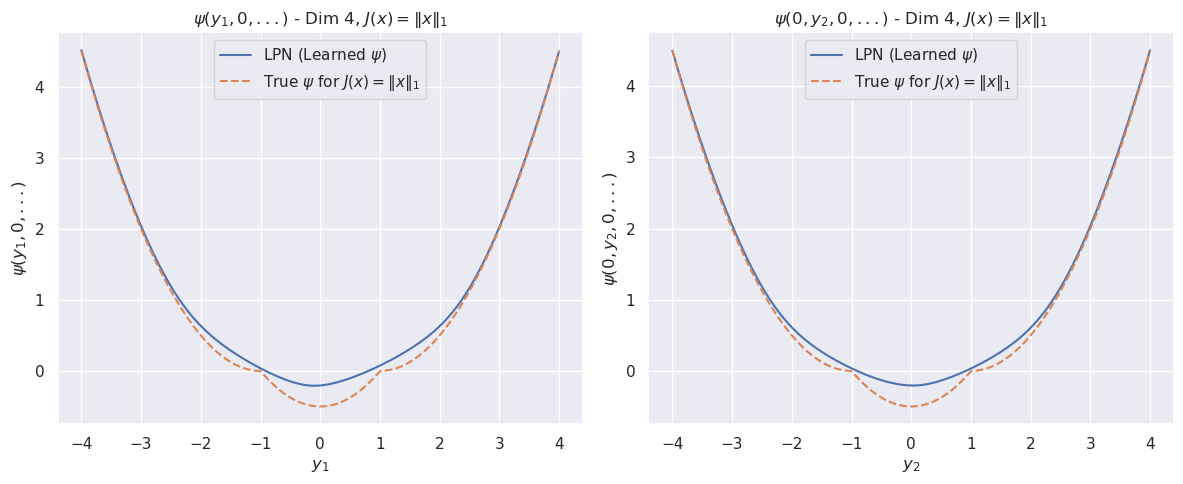

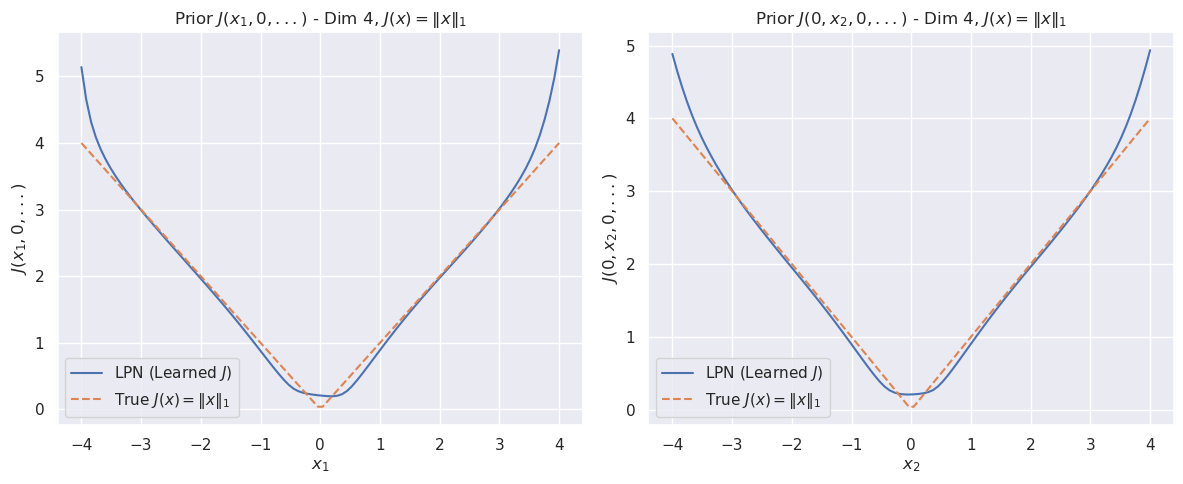

In [8]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

psi_x_k = lpn_model_quad_l1.scalar(x_k_tensor)

y_k_tensor = lpn_model_quad_l1(x_k_tensor)

inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

tensor([[-0.4482,  0.7489, -2.9135, -0.6597],
        [-1.8383, -2.2746, -1.4962, -0.5300],
        [-0.4572,  0.3240, -0.4118,  0.6053],
        ...,
        [ 2.4221, -0.5126,  0.4172, -0.8483],
        [-2.6039, -2.6930, -1.5745, -2.9255],
        [ 0.5408,  2.2457,  2.3164,  0.5759]], device='cuda:0')

In [10]:
# --- Step 3: Train 2nd LPN ---
print("\n--- Training Second LPN for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=1, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN for Concave Quadratic Prior ---
iteration 0 loss 8.459599494934082
iteration 0 loss 348.1086730957031


iteration 500 loss 4.522281169891357


iteration 1000 loss 4.207655906677246


iteration 1500 loss 3.7113757133483887


iteration 2000 loss 2.977046012878418


iteration 2500 loss 2.12723445892334


iteration 3000 loss 1.2545056343078613


iteration 3500 loss 0.5417607426643372


iteration 4000 loss 0.17125992476940155


iteration 4500 loss 0.05671287700533867


iteration 5000 loss 0.02632313221693039


iteration 5500 loss 0.015148395672440529


iteration 6000 loss 0.010427876375615597


iteration 6500 loss 0.008392608724534512


iteration 7000 loss 0.007379406597465277


iteration 7500 loss 0.006709360517561436


iteration 8000 loss 0.006177357863634825


iteration 8500 loss 0.005738320294767618


iteration 9000 loss 0.005369122140109539


iteration 9500 loss 0.005058826878666878


iteration 10000 loss 0.0048079476691782475


iteration 10500 loss 0.004601094871759415


iteration 11000 loss 0.004487918224185705


iteration 11500 loss 0.0044028256088495255


iteration 12000 loss 0.004316090140491724


iteration 12500 loss 0.004226680379360914


iteration 13000 loss 0.00416924711316824


iteration 13500 loss 0.004114421550184488


iteration 14000 loss 0.004080857150256634


iteration 14500 loss 0.004042613320052624


iteration 15000 loss 0.003999005071818829


iteration 15500 loss 0.00394933857023716


iteration 16000 loss 0.003909582272171974


iteration 16500 loss 0.0038905444089323282


iteration 17000 loss 0.003871217602863908


iteration 17500 loss 0.003848806954920292


iteration 18000 loss 0.003821838181465864


iteration 18500 loss 0.003789507085457444


iteration 19000 loss 0.0037857748102396727


iteration 19500 loss 0.0037439570296555758


iteration 20000 loss 0.003728175302967429


iteration 20500 loss 0.0037094352301210165


iteration 21000 loss 0.0036865759175270796


iteration 21500 loss 0.0036584436893463135


iteration 22000 loss 0.003639174159616232


iteration 22500 loss 0.003620810341089964


iteration 23000 loss 0.003598123090341687


iteration 23500 loss 0.0035696502309292555


iteration 24000 loss 0.0035522046964615583


iteration 24500 loss 0.003536081872880459


iteration 25000 loss 0.0035159788094460964


iteration 25500 loss 0.0034905849024653435


iteration 26000 loss 0.003524795873090625


iteration 26500 loss 0.003451842814683914


iteration 27000 loss 0.0034372394438833


iteration 27500 loss 0.0034190600272268057


iteration 28000 loss 0.0033965734764933586


iteration 28500 loss 0.003368583507835865


iteration 29000 loss 0.0033582893665879965


iteration 29500 loss 0.0033469977788627148


iteration 30000 loss 0.0033335620537400246


iteration 30500 loss 0.0033166594803333282


iteration 31000 loss 0.0032954546622931957


iteration 31500 loss 0.0032781241461634636


iteration 32000 loss 0.003265618346631527


iteration 32500 loss 0.003251359099522233


iteration 33000 loss 0.0032337866723537445


iteration 33500 loss 0.00321159022860229


iteration 34000 loss 0.003198558697476983


iteration 34500 loss 0.0031852542888373137


iteration 35000 loss 0.0031687754672020674


iteration 35500 loss 0.0031478290911763906


iteration 36000 loss 0.0031304839067161083


iteration 36500 loss 0.003119547851383686


iteration 37000 loss 0.003107950557023287


iteration 37500 loss 0.0030935730319470167


iteration 38000 loss 0.0030753277242183685


iteration 38500 loss 0.0030725477263331413


iteration 39000 loss 0.0030437703244388103


iteration 39500 loss 0.003029666841030121


iteration 40000 loss 0.0030119111761450768


iteration 40500 loss 0.002989408327266574


iteration 41000 loss 0.0029782785568386316


iteration 41500 loss 0.002966996980831027


iteration 42000 loss 0.0029535030480474234


iteration 42500 loss 0.002936459379270673


iteration 43000 loss 0.002914599608629942


iteration 43500 loss 0.002900458872318268


iteration 44000 loss 0.0028875856660306454


iteration 44500 loss 0.0028718358371406794


iteration 45000 loss 0.002851720666512847


iteration 45500 loss 0.002834806451573968


iteration 46000 loss 0.002821490401402116


iteration 46500 loss 0.002805679338052869


iteration 47000 loss 0.002785582561045885


iteration 47500 loss 0.00277046044357121


iteration 48000 loss 0.0027591304387897253


iteration 48500 loss 0.0027458076365292072


iteration 49000 loss 0.0027291537262499332


iteration 49500 loss 0.0027079235296696424


iteration 50000 loss 0.00269602844491601


iteration 50500 loss 0.0026846446562558413


iteration 51000 loss 0.0026709039229899645


iteration 51500 loss 0.00265342160128057


iteration 52000 loss 0.0026322444900870323


iteration 52500 loss 0.002621919848024845


iteration 53000 loss 0.002609659917652607


iteration 53500 loss 0.0025943927466869354


iteration 54000 loss 0.0025748766493052244


iteration 54500 loss 0.002558312378823757


iteration 55000 loss 0.002546163508668542


iteration 55500 loss 0.002532527782022953


iteration 56000 loss 0.0025153078604489565


iteration 56500 loss 0.0024932303931564093


iteration 57000 loss 0.002478998387232423


iteration 57500 loss 0.0024664776865392923


iteration 58000 loss 0.0024514400865882635


iteration 58500 loss 0.0024323316756635904


iteration 59000 loss 0.0024078143760561943


iteration 59500 loss 0.0023949402384459972


iteration 60000 loss 0.00238143396563828


iteration 60500 loss 0.0023647593334317207


iteration 61000 loss 0.0023437540512531996


iteration 61500 loss 0.002317024627700448


iteration 62000 loss 0.0023069679737091064


iteration 62500 loss 0.002296830527484417


iteration 63000 loss 0.002284795045852661


iteration 63500 loss 0.0022696128580719233


iteration 64000 loss 0.0022502022329717875


iteration 64500 loss 0.0022254150826483965


iteration 65000 loss 0.002213138621300459


iteration 65500 loss 0.0022026237566024065


iteration 66000 loss 0.0021902003791183233


iteration 66500 loss 0.0021744610276073217


iteration 67000 loss 0.0021543209441006184


iteration 67500 loss 0.0021287084091454744


iteration 68000 loss 0.0021167995873838663


iteration 68500 loss 0.0021070365328341722


iteration 69000 loss 0.0020958702079951763


iteration 69500 loss 0.0020819033961743116


iteration 70000 loss 0.00206412049010396


iteration 70500 loss 0.0020413189195096493


iteration 71000 loss 0.0020270608365535736


iteration 71500 loss 0.0020129678305238485


iteration 72000 loss 0.001995923463255167


iteration 72500 loss 0.0019743444863706827


iteration 73000 loss 0.001957949250936508


iteration 73500 loss 0.0019471473060548306


iteration 74000 loss 0.001936253858730197


iteration 74500 loss 0.0019229520112276077


iteration 75000 loss 0.0019061221973970532


iteration 75500 loss 0.0018847030587494373


iteration 76000 loss 0.0018712067976593971


iteration 76500 loss 0.0018601107876747847


iteration 77000 loss 0.001847464358434081


iteration 77500 loss 0.001831640605814755


iteration 78000 loss 0.0018115101847797632


iteration 78500 loss 0.0017986207967624068


iteration 79000 loss 0.0017881827661767602


iteration 79500 loss 0.0017764102667570114


iteration 80000 loss 0.0017616862896829844


iteration 80500 loss 0.0017430325970053673


iteration 81000 loss 0.0023201960138976574


iteration 81500 loss 0.0017151160864159465


iteration 82000 loss 0.001705389702692628


iteration 82500 loss 0.0016938045155256987


iteration 83000 loss 0.001679205452091992


iteration 83500 loss 0.0016606574645265937


iteration 84000 loss 0.0016437220619991422


iteration 84500 loss 0.0016324811149388552


iteration 85000 loss 0.0016213550698012114


iteration 85500 loss 0.0016074489103630185


iteration 86000 loss 0.00158981722779572


iteration 86500 loss 0.0015673848101869226


iteration 87000 loss 0.0015567918308079243


iteration 87500 loss 0.001546322600916028


iteration 88000 loss 0.001534178270958364


iteration 88500 loss 0.001518908073194325


iteration 89000 loss 0.001499529811553657


iteration 89500 loss 0.0014822103548794985


iteration 90000 loss 0.0014698663726449013


iteration 90500 loss 0.0014573996886610985


iteration 91000 loss 0.0014418745413422585


iteration 91500 loss 0.0014221288729459047


iteration 92000 loss 0.0014067693846300244


iteration 92500 loss 0.001396527630276978


iteration 93000 loss 0.0013872705167159438


iteration 93500 loss 0.0013762046582996845


iteration 94000 loss 0.001362308394163847


iteration 94500 loss 0.00134468253236264


iteration 95000 loss 0.0013349215732887387


iteration 95500 loss 0.0013203041162341833


iteration 96000 loss 0.0013119920622557402


iteration 96500 loss 0.0013023396022617817


iteration 97000 loss 0.0012902762973681092


iteration 97500 loss 0.0012750066816806793


iteration 98000 loss 0.0012618936598300934


iteration 98500 loss 0.0012513442197814584


iteration 99000 loss 0.0012412755750119686


iteration 99500 loss 0.0012289476580917835


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.0012133106356486678


iteration 100500 loss 0.0012113112024962902


iteration 101000 loss 0.0012087543727830052


iteration 101500 loss 0.0012054751859977841


iteration 102000 loss 0.0012012830702587962


iteration 102500 loss 0.0011959315743297338


iteration 103000 loss 0.001189115340821445


iteration 103500 loss 0.0011804475216194987


iteration 104000 loss 0.0011694877175614238


iteration 104500 loss 0.0011557057732716203


iteration 105000 loss 0.0011385346297174692


iteration 105500 loss 0.001117442618124187


iteration 106000 loss 0.0011108301114290953


iteration 106500 loss 0.001104098279029131


iteration 107000 loss 0.0010955872712656856


iteration 107500 loss 0.001084907096810639


iteration 108000 loss 0.0010715255048125982


iteration 108500 loss 0.0010548614664003253


iteration 109000 loss 0.0010345085756853223


iteration 109500 loss 0.0010282456642016768


iteration 110000 loss 0.0010217421222478151


iteration 110500 loss 0.0010135824559256434


iteration 111000 loss 0.0010033822618424892


iteration 111500 loss 0.0009907385101541877


iteration 112000 loss 0.0009750947938300669


iteration 112500 loss 0.0009583791252225637


iteration 113000 loss 0.0009518507868051529


iteration 113500 loss 0.0009436279069632292


iteration 114000 loss 0.0009332895861007273


iteration 114500 loss 0.0009204422822222114


iteration 115000 loss 0.0009046061313711107


iteration 115500 loss 0.0008920003892853856


iteration 116000 loss 0.0008871009340509772


iteration 116500 loss 0.0008808978600427508


iteration 117000 loss 0.0008730441913940012


iteration 117500 loss 0.0008631490636616945


iteration 118000 loss 0.0008508330793119967


iteration 118500 loss 0.000835674291010946


iteration 119000 loss 0.0008237005094997585


iteration 119500 loss 0.0008176208357326686


iteration 120000 loss 0.0008099397527985275


iteration 120500 loss 0.0008002941031008959


iteration 121000 loss 0.000788281497079879


iteration 121500 loss 0.0007734908722341061


iteration 122000 loss 0.000763993535656482


iteration 122500 loss 0.0007575980853289366


iteration 123000 loss 0.0007495476747862995


iteration 123500 loss 0.0007394700078293681


iteration 124000 loss 0.0007269952329806983


iteration 124500 loss 0.0007135036285035312


iteration 125000 loss 0.0007095802575349808


iteration 125500 loss 0.0007048346451483667


iteration 126000 loss 0.0006988422246649861


iteration 126500 loss 0.0006913237157277763


iteration 127000 loss 0.0006819498958066106


iteration 127500 loss 0.0006704065599478781


iteration 128000 loss 0.000659713929053396


iteration 128500 loss 0.0006566127412952483


iteration 129000 loss 0.0006527160294353962


iteration 129500 loss 0.0006477897404693067


iteration 130000 loss 0.000641602382529527


iteration 130500 loss 0.0006339133251458406


iteration 131000 loss 0.0006243882235139608


iteration 131500 loss 0.0006127665401436388


iteration 132000 loss 0.0006081170868128538


iteration 132500 loss 0.000605015957262367


iteration 133000 loss 0.0006010934012010694


iteration 133500 loss 0.0005961537826806307


iteration 134000 loss 0.0005899799289181828


iteration 134500 loss 0.00058231211733073


iteration 135000 loss 0.0005728714168071747


iteration 135500 loss 0.000565450987778604


iteration 136000 loss 0.0005630165687762201


iteration 136500 loss 0.000559952633921057


iteration 137000 loss 0.0005560813006013632


iteration 137500 loss 0.0005512198549695313


iteration 138000 loss 0.0005451433244161308


iteration 138500 loss 0.0005376343615353107


iteration 139000 loss 0.0005285118822939694


iteration 139500 loss 0.0005239914753474295


iteration 140000 loss 0.0005216368590481579


iteration 140500 loss 0.0005186641355976462


iteration 141000 loss 0.0005149210919626057


iteration 141500 loss 0.0005102342693135142


iteration 142000 loss 0.0005044018034823239


iteration 142500 loss 0.0004971942980773747


iteration 143000 loss 0.0004901281208731234


iteration 143500 loss 0.00048708246322348714


iteration 144000 loss 0.0004832809208892286


iteration 144500 loss 0.0004785336786881089


iteration 145000 loss 0.00047265528701245785


iteration 145500 loss 0.0004654410295188427


iteration 146000 loss 0.0004611194599419832


iteration 146500 loss 0.0004582627152558416


iteration 147000 loss 0.00045467651216313243


iteration 147500 loss 0.00045019545359537005


iteration 148000 loss 0.0004446251841727644


iteration 148500 loss 0.0004377785953693092


iteration 149000 loss 0.00043459623702801764


iteration 149500 loss 0.00043180983630008996


iteration 150000 loss 0.0004283181915525347


iteration 150500 loss 0.00042397965444251895


iteration 151000 loss 0.000418650422943756


iteration 151500 loss 0.0004127425199840218


iteration 152000 loss 0.00041075472836382687


iteration 152500 loss 0.0004084131505805999


iteration 153000 loss 0.0004054709861520678


iteration 153500 loss 0.0004017852188553661


iteration 154000 loss 0.0003972187405452132


iteration 154500 loss 0.0003916408459190279


iteration 155000 loss 0.000390387955121696


iteration 155500 loss 0.0003889880608767271


iteration 156000 loss 0.0003872130182571709


iteration 156500 loss 0.00038496701745316386


iteration 157000 loss 0.0003821397549472749


iteration 157500 loss 0.0003785933367908001


iteration 158000 loss 0.0003741836117114872


iteration 158500 loss 0.0003703666152432561


iteration 159000 loss 0.00036845961585640907


iteration 159500 loss 0.0003660579677671194


iteration 160000 loss 0.00036303504020906985


iteration 160500 loss 0.0003592546854633838


iteration 161000 loss 0.00035457737976685166


iteration 161500 loss 0.00035306005156598985


iteration 162000 loss 0.00035193481016904116


iteration 162500 loss 0.000350510876160115


iteration 163000 loss 0.0003487028006929904


iteration 163500 loss 0.00034641596721485257


iteration 164000 loss 0.00034353771479800344


iteration 164500 loss 0.00033995346166193485


iteration 165000 loss 0.0003361280250828713


iteration 165500 loss 0.00033514940878376365


iteration 166000 loss 0.00033404550049453974


iteration 166500 loss 0.00033264359808526933


iteration 167000 loss 0.00033086538314819336


iteration 167500 loss 0.00032861813087947667


iteration 168000 loss 0.0003257921489421278


iteration 168500 loss 0.0003222797531634569


iteration 169000 loss 0.0003199402126483619


iteration 169500 loss 0.00031879209564067423


iteration 170000 loss 0.0003173376026097685


iteration 170500 loss 0.0003154955920763314


iteration 171000 loss 0.00031317255343310535


iteration 171500 loss 0.0003102623741142452


iteration 172000 loss 0.00030664654332213104


iteration 172500 loss 0.00030575369601137936


iteration 173000 loss 0.0003048568032681942


iteration 173500 loss 0.0003037183778360486


iteration 174000 loss 0.0003022718010470271


iteration 174500 loss 0.00030043962760828435


iteration 175000 loss 0.0002981310826726258


iteration 175500 loss 0.00029525189893320203


iteration 176000 loss 0.00029250376974232495


iteration 176500 loss 0.00029132800409570336


iteration 177000 loss 0.0002898552920669317


iteration 177500 loss 0.00028799171559512615


iteration 178000 loss 0.00028564498643390834


iteration 178500 loss 0.00028271315386518836


iteration 179000 loss 0.0002808375284075737


iteration 179500 loss 0.00027979229344055057


iteration 180000 loss 0.000278471881756559


iteration 180500 loss 0.00027680210769176483


iteration 181000 loss 0.00027470517670735717


iteration 181500 loss 0.00027209267136640847


iteration 182000 loss 0.00027059658896178007


iteration 182500 loss 0.00026986232842318714


iteration 183000 loss 0.0002689356333576143


iteration 183500 loss 0.00026775742298923433


iteration 184000 loss 0.0002662647166289389


iteration 184500 loss 0.0002643835614435375


iteration 185000 loss 0.00026202574372291565


iteration 185500 loss 0.0002600409497972578


iteration 186000 loss 0.0002590609365142882


iteration 186500 loss 0.00025782588636502624


iteration 187000 loss 0.00025626280694268644


iteration 187500 loss 0.00025429605739191175


iteration 188000 loss 0.0002518389082979411


iteration 188500 loss 0.0002509242913220078


iteration 189000 loss 0.00025036418810486794


iteration 189500 loss 0.00024965908960439265


iteration 190000 loss 0.0002487626043148339


iteration 190500 loss 0.00024762461544014513


iteration 191000 loss 0.00024618415045551956


iteration 191500 loss 0.000244373717578128


iteration 192000 loss 0.0002425788843538612


iteration 192500 loss 0.0002420620439806953


iteration 193000 loss 0.00024147653311956674


iteration 193500 loss 0.00024073121312540025


iteration 194000 loss 0.0002397846692474559


iteration 194500 loss 0.00023858346685301512


iteration 195000 loss 0.0002370655711274594


iteration 195500 loss 0.00023516296641901135


iteration 196000 loss 0.00023389028501696885


iteration 196500 loss 0.00023331675038207322


iteration 197000 loss 0.00023259638692252338


iteration 197500 loss 0.00023168200277723372


iteration 198000 loss 0.0002305225352756679


iteration 198500 loss 0.00022905827790964395


iteration 199000 loss 0.00022722172434441745


iteration 199500 loss 0.00022628407168667763


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.00022583446116186678


iteration 200500 loss 0.0002257763990201056


iteration 201000 loss 0.00022570419241674244


iteration 201500 loss 0.0002256127045257017


iteration 202000 loss 0.00022549624554812908


iteration 202500 loss 0.00022534638992510736


iteration 203000 loss 0.000225154246436432


iteration 203500 loss 0.000224913761485368


iteration 204000 loss 0.00022461028129328042


iteration 204500 loss 0.00022422966139856726


iteration 205000 loss 0.00022376021661330014


iteration 205500 loss 0.00022318896662909538


iteration 206000 loss 0.00022250303300097585


iteration 206500 loss 0.0002216962311649695


iteration 207000 loss 0.00022076141613069922


iteration 207500 loss 0.00021969903900753707


iteration 208000 loss 0.0002187739301007241


iteration 208500 loss 0.00021815458603668958


iteration 209000 loss 0.0002174272231059149


iteration 209500 loss 0.00021658159676007926


iteration 210000 loss 0.00021561245375778526


iteration 210500 loss 0.00021464489691425115


iteration 211000 loss 0.00021406961604952812


iteration 211500 loss 0.00021339034719858319


iteration 212000 loss 0.00021259883942548186


iteration 212500 loss 0.00021169132378417999


iteration 213000 loss 0.00021068887144792825


iteration 213500 loss 0.0002100467827403918


iteration 214000 loss 0.00020930104074068367


iteration 214500 loss 0.00020844259415753186


iteration 215000 loss 0.00020747141388710588


iteration 215500 loss 0.00020690521341748536


iteration 216000 loss 0.0002063514111796394


iteration 216500 loss 0.00020569885964505374


iteration 217000 loss 0.0002049374597845599


iteration 217500 loss 0.00020406607654877007


iteration 218000 loss 0.0002031857002293691


iteration 218500 loss 0.00020253674301784486


iteration 219000 loss 0.00020178276463411748


iteration 219500 loss 0.00020092169870622456


iteration 220000 loss 0.00020016569760628045


iteration 220500 loss 0.00019967628759332


iteration 221000 loss 0.00019909910042770207


iteration 221500 loss 0.00019842199981212616


iteration 222000 loss 0.00019763957243412733


iteration 222500 loss 0.00019675084331538528


iteration 223000 loss 0.00019625313871074468


iteration 223500 loss 0.00019573669123928994


iteration 224000 loss 0.00019512760627549142


iteration 224500 loss 0.00019441722542978823


iteration 225000 loss 0.0001936056069098413


iteration 225500 loss 0.00019288538896944374


iteration 226000 loss 0.00019245370640419424


iteration 226500 loss 0.00019194517517462373


iteration 227000 loss 0.00019134592730551958


iteration 227500 loss 0.00019064790103584528


iteration 228000 loss 0.0001898513874039054


iteration 228500 loss 0.00018918828573077917


iteration 229000 loss 0.00018867352628149092


iteration 229500 loss 0.0001880699855973944


iteration 230000 loss 0.00018736824858933687


iteration 230500 loss 0.000186568868230097


iteration 231000 loss 0.00018600383191369474


iteration 231500 loss 0.00018543930491432548


iteration 232000 loss 0.00018478072888683528


iteration 232500 loss 0.00018402979185339063


iteration 233000 loss 0.00018344396085012704


iteration 233500 loss 0.00018305372213944793


iteration 234000 loss 0.0001825885265134275


iteration 234500 loss 0.0001820403995225206


iteration 235000 loss 0.00018140088650397956


iteration 235500 loss 0.00018066920165438205


iteration 236000 loss 0.00018014373199548572


iteration 236500 loss 0.00017974105139728636


iteration 237000 loss 0.00017926582950167358


iteration 237500 loss 0.00017870828742161393


iteration 238000 loss 0.00017805941752158105


iteration 238500 loss 0.00017732061678543687


iteration 239000 loss 0.0001768297079252079


iteration 239500 loss 0.0001762917236192152


iteration 240000 loss 0.0001756646524881944


iteration 240500 loss 0.00017494955682195723


iteration 241000 loss 0.00017455768829677254


iteration 241500 loss 0.00017419569485355169


iteration 242000 loss 0.00017376379400957376


iteration 242500 loss 0.00017325994849670678


iteration 243000 loss 0.0001726723276078701


iteration 243500 loss 0.00017199765716213733


iteration 244000 loss 0.00017157343972939998


iteration 244500 loss 0.00017123068391811103


iteration 245000 loss 0.00017081951955333352


iteration 245500 loss 0.00017033368931151927


iteration 246000 loss 0.00016976642655208707


iteration 246500 loss 0.00016911498096305877


iteration 247000 loss 0.00016868853708729148


iteration 247500 loss 0.00016835442511364818


iteration 248000 loss 0.00016795362171251327


iteration 248500 loss 0.00016747995687182993


iteration 249000 loss 0.00016692707140464336


iteration 249500 loss 0.0001662932918407023


iteration 250000 loss 0.00016584410332143307


iteration 250500 loss 0.00016541453078389168


iteration 251000 loss 0.000164911150932312


iteration 251500 loss 0.00016432488337159157


iteration 252000 loss 0.00016380152374040335


iteration 252500 loss 0.00016348967619705945


iteration 253000 loss 0.00016311353829223663


iteration 253500 loss 0.00016267012688331306


iteration 254000 loss 0.0001621516130398959


iteration 254500 loss 0.0001615560904610902


iteration 255000 loss 0.00016118369239848107


iteration 255500 loss 0.00016088988923002034


iteration 256000 loss 0.00016053489525802433


iteration 256500 loss 0.00016011380648706108


iteration 257000 loss 0.00015962125326041132


iteration 257500 loss 0.0001590514148119837


iteration 258000 loss 0.00015861174324527383


iteration 258500 loss 0.00015822853310965002


iteration 259000 loss 0.00015777864609844983


iteration 259500 loss 0.000157253016368486


iteration 260000 loss 0.00015675200847908854


iteration 260500 loss 0.000156514419359155


iteration 261000 loss 0.0001562304241815582


iteration 261500 loss 0.00015588705718982965


iteration 262000 loss 0.0001554799237055704


iteration 262500 loss 0.0001550028973724693


iteration 263000 loss 0.00015445254393853247


iteration 263500 loss 0.00015417070244438946


iteration 264000 loss 0.00015390565386042


iteration 264500 loss 0.00015358944074250758


iteration 265000 loss 0.0001532103051431477


iteration 265500 loss 0.00015276578778866678


iteration 266000 loss 0.00015225002425722778


iteration 266500 loss 0.00015189485566224903


iteration 267000 loss 0.00015165162039920688


iteration 267500 loss 0.0001513604656793177


iteration 268000 loss 0.00015101009921636432


iteration 268500 loss 0.00015059734869282693


iteration 269000 loss 0.00015011608775239438


iteration 269500 loss 0.00014969840412959456


iteration 270000 loss 0.00014945876318961382


iteration 270500 loss 0.00014917230873834342


iteration 271000 loss 0.0001488269044784829


iteration 271500 loss 0.00014842029486317188


iteration 272000 loss 0.00014794447633903474


iteration 272500 loss 0.00014756733435206115


iteration 273000 loss 0.0001473500014981255


iteration 273500 loss 0.00014708847447764128


iteration 274000 loss 0.00014677141734864563


iteration 274500 loss 0.00014639845176134259


iteration 275000 loss 0.0001459608320146799


iteration 275500 loss 0.00014549310435540974


iteration 276000 loss 0.00014529690088238567


iteration 276500 loss 0.00014505941362585872


iteration 277000 loss 0.00014477455988526344


iteration 277500 loss 0.00014443240070249885


iteration 278000 loss 0.0001440297783119604


iteration 278500 loss 0.00014356119208969176


iteration 279000 loss 0.00014324304356705397


iteration 279500 loss 0.0001429445546818897


iteration 280000 loss 0.0001425906812073663


iteration 280500 loss 0.0001421750639565289


iteration 281000 loss 0.00014171206566970795


iteration 281500 loss 0.00014153723896015435


iteration 282000 loss 0.00014132692012935877


iteration 282500 loss 0.00014107405149843544


iteration 283000 loss 0.0001407674717484042


iteration 283500 loss 0.0001404037611791864


iteration 284000 loss 0.00013997814676258713


iteration 284500 loss 0.00013963562378194183


iteration 285000 loss 0.000139434210723266


iteration 285500 loss 0.00013919157208874822


iteration 286000 loss 0.000138898438308388


iteration 286500 loss 0.00013854930875822902


iteration 287000 loss 0.00013813978875987232


iteration 287500 loss 0.00013775481784250587


iteration 288000 loss 0.00013748332276009023


iteration 288500 loss 0.00013716035755351186


iteration 289000 loss 0.00013678187679033726


iteration 289500 loss 0.00013638075324706733


iteration 290000 loss 0.00013618383673019707


iteration 290500 loss 0.00013598498480860144


iteration 291000 loss 0.00013574535842053592


iteration 291500 loss 0.00013545526599045843


iteration 292000 loss 0.00013511069118976593


iteration 292500 loss 0.00013470696285367012


iteration 293000 loss 0.0001344168558716774


iteration 293500 loss 0.00013420841423794627


iteration 294000 loss 0.00013395817950367928


iteration 294500 loss 0.00013365643098950386


iteration 295000 loss 0.00013330027286428958


iteration 295500 loss 0.00013351187226362526


iteration 296000 loss 0.00013269195915199816


iteration 296500 loss 0.00013245978334452957


iteration 297000 loss 0.00013217813102528453


iteration 297500 loss 0.0001318454451393336


iteration 298000 loss 0.0001314560795435682


iteration 298500 loss 0.0001312344247708097


iteration 299000 loss 0.00013106073311064392


iteration 299500 loss 0.0001308498758589849


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.0001305954938288778


iteration 300500 loss 0.0001305610203417018


iteration 301000 loss 0.00013052132271695882


iteration 301500 loss 0.0001304752513533458


iteration 302000 loss 0.00013042314094491303


iteration 302500 loss 0.0001303633616771549


iteration 303000 loss 0.0001302968303207308


iteration 303500 loss 0.0001302236196352169


iteration 304000 loss 0.00013014224532525986


iteration 304500 loss 0.00013005203800275922


iteration 305000 loss 0.0001299545547226444


iteration 305500 loss 0.00012985130888409913


iteration 306000 loss 0.00012974311539437622


iteration 306500 loss 0.0001296309637837112


iteration 307000 loss 0.00012951884127687663


iteration 307500 loss 0.00012940795568283647


iteration 308000 loss 0.00012929765216540545


iteration 308500 loss 0.00012918829452246428


iteration 309000 loss 0.00012907989730592817


iteration 309500 loss 0.00012897179112769663


iteration 310000 loss 0.00012886442709714174


iteration 310500 loss 0.00012875704851467162


iteration 311000 loss 0.00012864996097050607


iteration 311500 loss 0.00012854328087996691


iteration 312000 loss 0.0001284373865928501


iteration 312500 loss 0.00012833137589041144


iteration 313000 loss 0.00012822602002415806


iteration 313500 loss 0.00012812107161153108


iteration 314000 loss 0.00012801606499124318


iteration 314500 loss 0.00012791159679181874


iteration 315000 loss 0.00012780699762515724


iteration 315500 loss 0.00012770359171554446


iteration 316000 loss 0.00012759964738506824


iteration 316500 loss 0.00012750012683682144


iteration 317000 loss 0.00012739714293275028


iteration 317500 loss 0.00012729440641123801


iteration 318000 loss 0.00012719182996079326


iteration 318500 loss 0.00012708950089290738


iteration 319000 loss 0.0001269894273718819


iteration 319500 loss 0.00012688782589975744


iteration 320000 loss 0.00012678616621997207


iteration 320500 loss 0.00012668421550188214


iteration 321000 loss 0.0001265831378987059


iteration 321500 loss 0.0001264821330551058


iteration 322000 loss 0.00012638118641916662


iteration 322500 loss 0.00012628080730792135


iteration 323000 loss 0.0001261802826775238


iteration 323500 loss 0.0001260799908777699


iteration 324000 loss 0.00012597999011632055


iteration 324500 loss 0.00012588012032210827


iteration 325000 loss 0.0001257807161891833


iteration 325500 loss 0.00012568103556986898


iteration 326000 loss 0.00012558160233311355


iteration 326500 loss 0.00012548250379040837


iteration 327000 loss 0.00012538359442260116


iteration 327500 loss 0.0001252845540875569


iteration 328000 loss 0.00012518599396571517


iteration 328500 loss 0.00012508773943409324


iteration 329000 loss 0.00012498944124672562


iteration 329500 loss 0.00012489152140915394


iteration 330000 loss 0.00012479431461542845


iteration 330500 loss 0.0001246964675374329


iteration 331000 loss 0.00012459937715902925


iteration 331500 loss 0.00012450198119040579


iteration 332000 loss 0.0001244049781234935


iteration 332500 loss 0.00012430774222593755


iteration 333000 loss 0.0001242107100551948


iteration 333500 loss 0.00012411412899382412


iteration 334000 loss 0.00012401769345160574


iteration 334500 loss 0.00012392093776725233


iteration 335000 loss 0.00012382461864035577


iteration 335500 loss 0.000123728605103679


iteration 336000 loss 0.0001236326206708327


iteration 336500 loss 0.00012353663623798639


iteration 337000 loss 0.00012344152492005378


iteration 337500 loss 0.0001233457587659359


iteration 338000 loss 0.0001232498761964962


iteration 338500 loss 0.00012315563799347728


iteration 339000 loss 0.0001230603811563924


iteration 339500 loss 0.0001229659974342212


iteration 340000 loss 0.0001228717592312023


iteration 340500 loss 0.00012277714267838746


iteration 341000 loss 0.0001226832828251645


iteration 341500 loss 0.00012258932110853493


iteration 342000 loss 0.00012249534483999014


iteration 342500 loss 0.00012240112118888646


iteration 343000 loss 0.0001223077269969508


iteration 343500 loss 0.0001222140563186258


iteration 344000 loss 0.00012212056026328355


iteration 344500 loss 0.00012202688230900094


iteration 345000 loss 0.00012193383736303076


iteration 345500 loss 0.0001218407487613149


iteration 346000 loss 0.00012174796574981883


iteration 346500 loss 0.00012165543739683926


iteration 347000 loss 0.0001215628144564107


iteration 347500 loss 0.00012147046072641388


iteration 348000 loss 0.00012137832527514547


iteration 348500 loss 0.00012128645175835118


iteration 349000 loss 0.00012119439634261653


iteration 349500 loss 0.0001211029157275334


iteration 350000 loss 0.00012101118045393378


iteration 350500 loss 0.00012091975804651156


iteration 351000 loss 0.00012082863395335153


iteration 351500 loss 0.00012073731340933591


iteration 352000 loss 0.00012064639304298908


iteration 352500 loss 0.00012055538536515087


iteration 353000 loss 0.00012046442861901596


iteration 353500 loss 0.00012037380656693131


iteration 354000 loss 0.00012028322089463472


iteration 354500 loss 0.0001201927152578719


iteration 355000 loss 0.00012010241334792227


iteration 355500 loss 0.00012001224240520969


iteration 356000 loss 0.00011992223153356463


iteration 356500 loss 0.00011983220611000434


iteration 357000 loss 0.00011974236986134201


iteration 357500 loss 0.00011965266457991675


iteration 358000 loss 0.00011956350499531254


iteration 358500 loss 0.00011947400344070047


iteration 359000 loss 0.0001193848074763082


iteration 359500 loss 0.00011929565516766161


iteration 360000 loss 0.00011920642282348126


iteration 360500 loss 0.00011911787441931665


iteration 361000 loss 0.00011902904225280508


iteration 361500 loss 0.00011894026829395443


iteration 362000 loss 0.00011885187268489972


iteration 362500 loss 0.00011876363714691252


iteration 363000 loss 0.00011867520515806973


iteration 363500 loss 0.00011858720245072618


iteration 364000 loss 0.00011849922884721309


iteration 364500 loss 0.00011841154628200457


iteration 365000 loss 0.00011832403833977878


iteration 365500 loss 0.00011823655950138345


iteration 366000 loss 0.00011814910976681858


iteration 366500 loss 0.00011806173279182985


iteration 367000 loss 0.00011797456681961194


iteration 367500 loss 0.00011788761185016483


iteration 368000 loss 0.00011780070053646341


iteration 368500 loss 0.00011771397112170234


iteration 369000 loss 0.00011762728536268696


iteration 369500 loss 0.0001175408178824


iteration 370000 loss 0.00011745435767807066


iteration 370500 loss 0.00011736800661310554


iteration 371000 loss 0.00011728205572580919


iteration 371500 loss 0.00011719605390680954


iteration 372000 loss 0.00011710994294844568


iteration 372500 loss 0.00011702420306392014


iteration 373000 loss 0.00011693880514940247


iteration 373500 loss 0.00011685317440424114


iteration 374000 loss 0.00011676754365907982


iteration 374500 loss 0.00011668226215988398


iteration 375000 loss 0.0001165972207672894


iteration 375500 loss 0.00011651207751128823


iteration 376000 loss 0.00011642701429082081


iteration 376500 loss 0.00011634223483270034


iteration 377000 loss 0.00011625733168330044


iteration 377500 loss 0.0001161726177087985


iteration 378000 loss 0.00011608796921791509


iteration 378500 loss 0.00011600407015066594


iteration 379000 loss 0.00011591972725000232


iteration 379500 loss 0.0001158358936663717


iteration 380000 loss 0.00011575202370295301


iteration 380500 loss 0.00011566808825591579


iteration 381000 loss 0.00011558453843463212


iteration 381500 loss 0.00011550071212695912


iteration 382000 loss 0.000115417547931429


iteration 382500 loss 0.0001153339326265268


iteration 383000 loss 0.00011525094305397943


iteration 383500 loss 0.0001151677206507884


iteration 384000 loss 0.00011508447641972452


iteration 384500 loss 0.00011500162509037182


iteration 385000 loss 0.00011491900659166276


iteration 385500 loss 0.00011483647540444508


iteration 386000 loss 0.00011475397332105786


iteration 386500 loss 0.00011467192962300032


iteration 387000 loss 0.0001145897331298329


iteration 387500 loss 0.00011450758756836876


iteration 388000 loss 0.00011442536924732849


iteration 388500 loss 0.00011434363113949075


iteration 389000 loss 0.00011426171840867028


iteration 389500 loss 0.00011418015492381528


iteration 390000 loss 0.00011409847502363846


iteration 390500 loss 0.00011401688971091062


iteration 391000 loss 0.00011393585009500384


iteration 391500 loss 0.00011385459947632626


iteration 392000 loss 0.00011377342889318243


iteration 392500 loss 0.00011369230196578428


iteration 393000 loss 0.0001136113642132841


iteration 393500 loss 0.00011353034642525017


iteration 394000 loss 0.00011345014354446903


iteration 394500 loss 0.0001133701516664587


iteration 395000 loss 0.00011328974505886436


iteration 395500 loss 0.00011320955672999844


iteration 396000 loss 0.00011312963761156425


iteration 396500 loss 0.0001130497912527062


iteration 397000 loss 0.00011296983575448394


iteration 397500 loss 0.00011288996756775305


iteration 398000 loss 0.0001128106887335889


iteration 398500 loss 0.00011273090785834938


iteration 399000 loss 0.00011265167995588854


iteration 399500 loss 0.00011257227015448734


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.00011249315139139071


iteration 400500 loss 0.00011248901864746585


iteration 401000 loss 0.00011248489317949861


iteration 401500 loss 0.00011248005466768518


iteration 402000 loss 0.00011247557267779484


iteration 402500 loss 0.00011247064685449004


iteration 403000 loss 0.00011246580834267661


iteration 403500 loss 0.00011246070789638907


iteration 404000 loss 0.00011245557834627107


iteration 404500 loss 0.00011245045607211068


iteration 405000 loss 0.00011244551569689065


iteration 405500 loss 0.00011244039342273027


iteration 406000 loss 0.00011243503104196861


iteration 406500 loss 0.00011243001790717244


iteration 407000 loss 0.00011242501204833388


iteration 407500 loss 0.00011241979518672451


iteration 408000 loss 0.00011241473839618266


iteration 408500 loss 0.00011240947060286999


iteration 409000 loss 0.00011240437743254006


iteration 409500 loss 0.00011239950254093856


iteration 410000 loss 0.00011239401646889746


iteration 410500 loss 0.00011238896695431322


iteration 411000 loss 0.0001123840338550508


iteration 411500 loss 0.00011237878788961098


iteration 412000 loss 0.00011237394210183993


iteration 412500 loss 0.00011236881982767954


iteration 413000 loss 0.00011236345744691789


iteration 413500 loss 0.00011235854617552832


iteration 414000 loss 0.00011235350393690169


iteration 414500 loss 0.00011234837438678369


iteration 415000 loss 0.00011234336852794513


iteration 415500 loss 0.00011233813711442053


iteration 416000 loss 0.00011233291297685355


iteration 416500 loss 0.0001123277033912018


iteration 417000 loss 0.00011232307588215917


iteration 417500 loss 0.00011231784446863458


iteration 418000 loss 0.00011231274402234703


iteration 418500 loss 0.00011230770905967802


iteration 419000 loss 0.00011230295785935596


iteration 419500 loss 0.0001122976973420009


iteration 420000 loss 0.00011229274241486564


iteration 420500 loss 0.00011228761286474764


iteration 421000 loss 0.00011228243965888396


iteration 421500 loss 0.00011227745562791824


iteration 422000 loss 0.00011227242794120684


iteration 422500 loss 0.00011226745846215636


iteration 423000 loss 0.00011226227070437744


iteration 423500 loss 0.00011225738126086071


iteration 424000 loss 0.00011225203343201429


iteration 424500 loss 0.00011224712943658233


iteration 425000 loss 0.00011224207264604047


iteration 425500 loss 0.00011223735782550648


iteration 426000 loss 0.00011223220644751564


iteration 426500 loss 0.00011222692410228774


iteration 427000 loss 0.00011222212924621999


iteration 427500 loss 0.00011221693421248347


iteration 428000 loss 0.00011221205932088196


iteration 428500 loss 0.0001122070025303401


iteration 429000 loss 0.00011220188753213733


iteration 429500 loss 0.00011219713633181527


iteration 430000 loss 0.00011219198495382443


iteration 430500 loss 0.00011218700092285872


iteration 431000 loss 0.00011218169674975798


iteration 431500 loss 0.00011217680003028363


iteration 432000 loss 0.00011217189603485167


iteration 432500 loss 0.00011216673738090321


iteration 433000 loss 0.00011216192069696262


iteration 433500 loss 0.00011215691483812407


iteration 434000 loss 0.00011215185804758221


iteration 434500 loss 0.00011214707774342969


iteration 435000 loss 0.00011214201367693022


iteration 435500 loss 0.00011213660036446527


iteration 436000 loss 0.00011213202378712595


iteration 436500 loss 0.0001121270761359483


iteration 437000 loss 0.00011212186655029655


iteration 437500 loss 0.00011211693345103413


iteration 438000 loss 0.00011211172386538237


iteration 438500 loss 0.00011210705997655168


iteration 439000 loss 0.00011210205411771312


iteration 439500 loss 0.00011209712101845071


iteration 440000 loss 0.00011209215881535783


iteration 440500 loss 0.00011208710202481598


iteration 441000 loss 0.00011208207433810458


iteration 441500 loss 0.00011207727220607921


iteration 442000 loss 0.00011207216448383406


iteration 442500 loss 0.00011206724593648687


iteration 443000 loss 0.00011206230556126684


iteration 443500 loss 0.00011205722694285214


iteration 444000 loss 0.0001120523302233778


iteration 444500 loss 0.00011204719339730218


iteration 445000 loss 0.00011204267502762377


iteration 445500 loss 0.00011203744361409917


iteration 446000 loss 0.00011203249596292153


iteration 446500 loss 0.00011202759196748957


iteration 447000 loss 0.00011202258610865101


iteration 447500 loss 0.0001120176020776853


iteration 448000 loss 0.00011201271991012618


iteration 448500 loss 0.00011200768494745716


iteration 449000 loss 0.0001120027300203219


iteration 449500 loss 0.00011199772416148335


iteration 450000 loss 0.00011199282016605139


iteration 450500 loss 0.00011198789434274659


iteration 451000 loss 0.00011198308493476361


iteration 451500 loss 0.00011197807179996744


iteration 452000 loss 0.00011197313870070502


iteration 452500 loss 0.00011196816922165453


iteration 453000 loss 0.00011196329433005303


iteration 453500 loss 0.00011195851402590051


iteration 454000 loss 0.00011195343540748581


iteration 454500 loss 0.00011194858234375715


iteration 455000 loss 0.00011194364924449474


iteration 455500 loss 0.00011193887621629983


iteration 456000 loss 0.00011193363025086


iteration 456500 loss 0.00011192878446308896


iteration 457000 loss 0.0001119239313993603


iteration 457500 loss 0.0001119192093028687


iteration 458000 loss 0.00011191398516530171


iteration 458500 loss 0.00011190919758519158


iteration 459000 loss 0.00011190430814167485


iteration 459500 loss 0.0001118993604904972


iteration 460000 loss 0.00011189472570549697


iteration 460500 loss 0.00011188964708708227


iteration 461000 loss 0.00011188466305611655


iteration 461500 loss 0.00011187999916728586


iteration 462000 loss 0.00011187495692865923


iteration 462500 loss 0.00011187004565726966


iteration 463000 loss 0.0001118650907301344


iteration 463500 loss 0.0001118601139751263


iteration 464000 loss 0.00011185525363544002


iteration 464500 loss 0.00011185028415638953


iteration 465000 loss 0.00011184567847521976


iteration 465500 loss 0.00011184053437318653


iteration 466000 loss 0.0001118357977247797


iteration 466500 loss 0.00011183092283317819


iteration 467000 loss 0.00011182580055901781


iteration 467500 loss 0.00011182124580955133


iteration 468000 loss 0.00011181607260368764


iteration 468500 loss 0.00011181137233506888


iteration 469000 loss 0.00011180655565112829


iteration 469500 loss 0.00011180152796441689


iteration 470000 loss 0.00011179684952367097


iteration 470500 loss 0.00011179182183695957


iteration 471000 loss 0.0001117867068387568


iteration 471500 loss 0.00011178216664120555


iteration 472000 loss 0.00011177707347087562


iteration 472500 loss 0.00011177235865034163


iteration 473000 loss 0.00011176751286257058


iteration 473500 loss 0.00011176257976330817


iteration 474000 loss 0.00011175758845638484


iteration 474500 loss 0.00011175291001563892


iteration 475000 loss 0.0001117477731895633


iteration 475500 loss 0.00011174300743732601


iteration 476000 loss 0.00011173824896104634


iteration 476500 loss 0.00011173329403391108


iteration 477000 loss 0.00011172857921337709


iteration 477500 loss 0.00011172358790645376


iteration 478000 loss 0.00011171897494932637


iteration 478500 loss 0.00011171382357133552


iteration 479000 loss 0.00011170906509505585


iteration 479500 loss 0.0001117043211706914


iteration 480000 loss 0.00011169912613695487


iteration 480500 loss 0.00011169451317982748


iteration 481000 loss 0.00011168963828822598


iteration 481500 loss 0.00011168498895131052


iteration 482000 loss 0.00011168004857609048


iteration 482500 loss 0.00011167511547682807


iteration 483000 loss 0.00011167027696501464


iteration 483500 loss 0.00011166544572915882


iteration 484000 loss 0.00011166049080202356


iteration 484500 loss 0.00011165567411808297


iteration 485000 loss 0.00011165109754074365


iteration 485500 loss 0.00011164636089233682


iteration 486000 loss 0.00011164141324115917


iteration 486500 loss 0.00011163656745338812


iteration 487000 loss 0.00011163172166561708


iteration 487500 loss 0.00011162687587784603


iteration 488000 loss 0.00011162209557369351


iteration 488500 loss 0.00011161737347720191


iteration 489000 loss 0.00011161229485878721


iteration 489500 loss 0.00011160755093442276


iteration 490000 loss 0.00011160292342538014


iteration 490500 loss 0.00011159791756654158


iteration 491000 loss 0.00011159300629515201


iteration 491500 loss 0.00011158839333802462


iteration 492000 loss 0.00011158354027429596


iteration 492500 loss 0.00011157872359035537


iteration 493000 loss 0.00011157379049109295


iteration 493500 loss 0.00011156903201481327


iteration 494000 loss 0.00011156420077895746


iteration 494500 loss 0.00011155948595842347


iteration 495000 loss 0.00011155477841384709


iteration 495500 loss 0.00011155019456055015


iteration 496000 loss 0.00011154513049405068


iteration 496500 loss 0.00011154021922266111


iteration 497000 loss 0.00011153530795127153


iteration 497500 loss 0.00011153073137393221


iteration 498000 loss 0.00011152606020914391


iteration 498500 loss 0.00011152103979839012


iteration 499000 loss 0.00011151613580295816


iteration 499500 loss 0.00011151139187859371


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


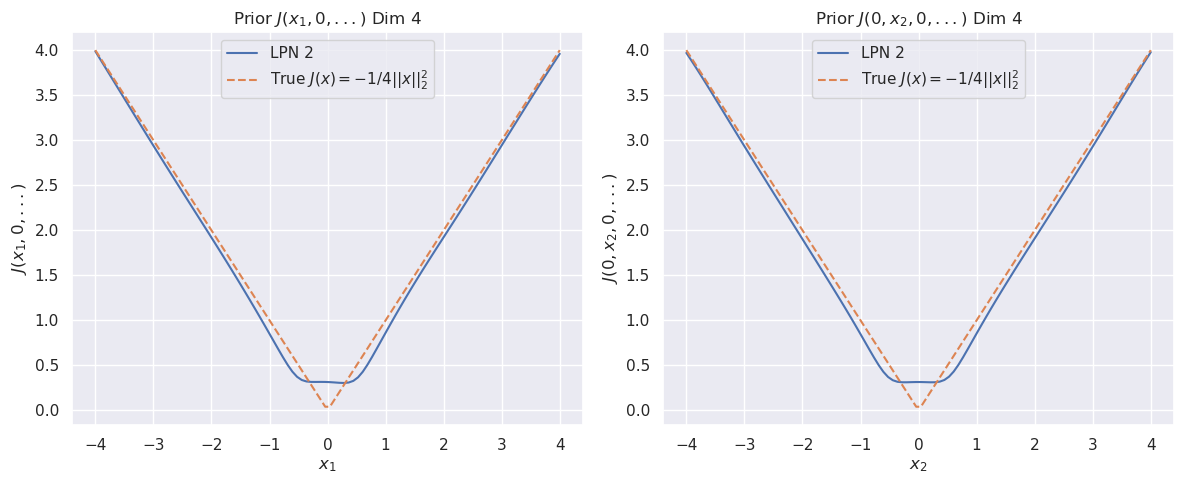

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)